In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/prostate.h5ad'
lymphoid_file = 'out/lymphoid.h5ad'
mnp_file = 'out/mnp.integrated.h5ad'
adata = sc.read_h5ad(results_file)
ldata = sc.read_h5ad(lymphoid_file)
mdata = sc.read_h5ad(mnp_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.2 scipy==1.5.3 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0


AnnData object with n_obs × n_vars = 17108 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Biopsy Location DETAIL', 'Biopsy Location BRIEF', 'Biopsy Location Co-ordinate', 'PMHx'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
adata.obs['celltype-immune'] = adata.obs['celltype']

In [3]:
adata.obs['celltype-immune'] = adata.obs['celltype-immune'].astype('object')

In [4]:
adata.obs['celltype-immune'].update(ldata.obs['celltype-immune'])
adata.obs['celltype-immune'].update(mdata.obs['celltype-immune'])

... storing 'celltype-immune' as categorical


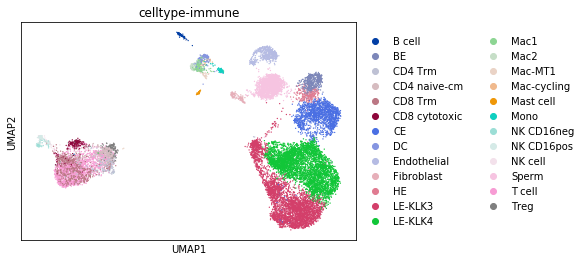

In [5]:
sc.pl.umap(adata, color = 'celltype-immune')

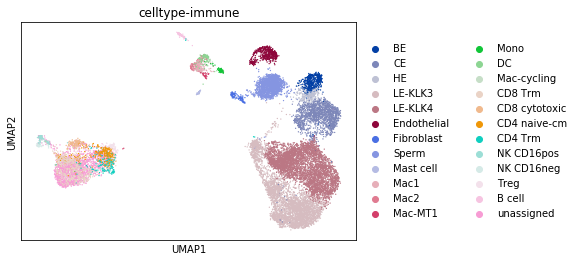

In [7]:
newdict = {
'BE':'BE',
'CE':'CE',
'HE':'HE',
'LE-KLK3':'LE-KLK3',
'LE-KLK4':'LE-KLK4',
'Endothelial':'Endothelial',
'Fibroblast':'Fibroblast',
'Sperm':'Sperm',
'Mast cell':'Mast cell',
'Mac1':'Mac1',
'Mac2':'Mac2',
'Mac-MT1':'Mac-MT1',
'Mono':'Mono',
'DC':'DC',
'Mac-cycling':'Mac-cycling',
'CD8 Trm':'CD8 Trm',
'CD8 cytotoxic':'CD8 cytotoxic',
'CD4 naive-cm':'CD4 naive-cm',
'CD4 Trm':'CD4 Trm',
'NK CD16pos':'NK CD16pos',
'NK CD16neg':'NK CD16neg',
'Treg':'Treg',
'B cell':'B cell',
'NK cell':'unassigned',
'T cell':'unassigned'
}
adata.obs['celltype-immune'] = [newdict[c] for c in adata.obs['celltype-immune']]
adata.obs['celltype-immune'] = adata.obs['celltype-immune'].astype('category')
adata.obs['celltype-immune'] = adata.obs['celltype-immune'].cat.reorder_categories(['BE', 'CE', 'HE', 'LE-KLK3', 'LE-KLK4', 'Endothelial', 'Fibroblast', 'Sperm', 'Mast cell', 'Mac1', 'Mac2', 'Mac-MT1', 'Mono', 'DC', 'Mac-cycling', 'CD8 Trm','CD8 cytotoxic','CD4 naive-cm','CD4 Trm','NK CD16pos','NK CD16neg','Treg', 'B cell', 'unassigned'])
sc.pl.umap(adata, color = 'celltype-immune')

In [8]:
adata.write('out/prostate.h5ad', compression = 'gzip')

In [9]:
adata = adata[~(adata.obs['celltype-immune'].isin(['Sperm', 'unassigned']))]
adata

View of AnnData object with n_obs × n_vars = 13505 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Biopsy Location DETAIL', 'Biopsy Location BRIEF', 'Biopsy Location Co-ordinate', 'PMHx', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap', 'celltype-immune_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [17]:
import re
[i for i in adata.raw.var.index if re.search('^TGFB', i)]

['TGFBR3',
 'TGFB2-AS1',
 'TGFB2',
 'TGFBRAP1',
 'TGFBR2',
 'TGFBI',
 'TGFBR1',
 'TGFB3',
 'TGFB1I1',
 'TGFBR3L',
 'TGFB1']

In [20]:
adata.obs['celltype-immune_group'] = [c + '_' + g for c,g in zip(adata.obs['celltype-immune'], adata.obs['group'])]

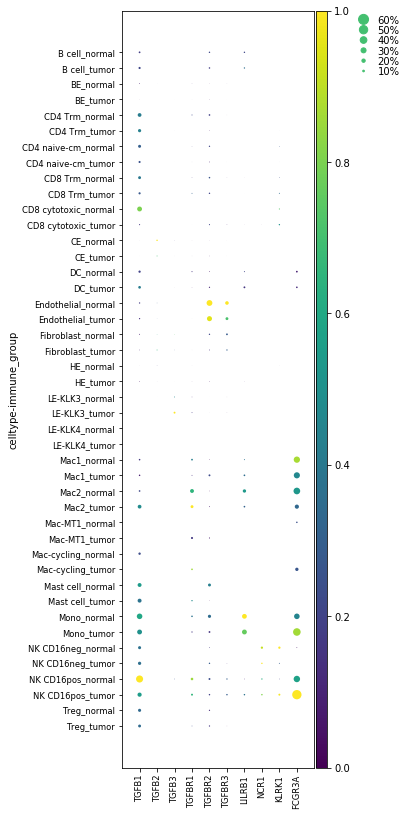

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [26]:
sc.pl.dotplot(adata, ['TGFB1', 'TGFB2', 'TGFB3', 'TGFBR1', 'TGFBR2', 'TGFBR3', 'LILRB1', 'NCR1', 'KLRK1', 'FCGR3A'], groupby = 'celltype-immune_group', color_map = 'viridis', standard_scale = 'var')

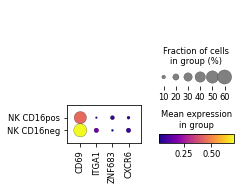

In [3]:
sc.pl.dotplot(nk, ['CD69', 'ITGA1', 'ZNF683', 'CXCR6'], groupby = 'celltype-immune', color_map = 'plasma')

In [ ]:
sc.pl.dotplot(adata, ['TGFB1'], groupby = 'celltype-immune', color_map = 'plasma')

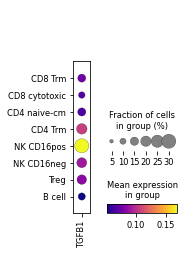

In [4]:
sc.pl.dotplot(adata, ['TGFB1'], groupby = 'celltype-immune', color_map = 'plasma')

In [66]:
# test geneset NK cell mediated cytotoxicity from GO
modules = {'NK cell-mediated cytotoxicity':['AP1G1', 'ARRB2', 'CADM1', 'CD160', 'CD226', 'CEACAM1', 'CEBPG', 'CLEC12B', 'CLEC2A', 'CORO1A', 'CRK', 'CRTAM', 'GZMB', 'HAVCR2', 'HLA-B', 'HLA-E', 'HLA-F', 'HLA-G', 'IL12A', 'IL12B', 'IL18', 'IL18RAP', 'IL21', 'KIR2DL4', 'KIR3DL1', 'KLRF2', 'KLRK1', 'LAG3', 'LAMP1', 'LEP', 'LGALS9', 'LILRB1', 'LYST', 'MICA', 'NCR1', 'NCR3', 'NECTIN2', 'PIK3R6', 'PRDX1', 'PTPN6', 'PVR', 'RAB27A', 'RAET1E', 'RAET1G', 'RASGRP1', 'SERPINB4', 'SERPINB9', 'SH2D1A', 'SLAMF6', 'SLAMF7', 'STAT5B', 'TUBB', 'TUBB4B', 'ULBP1', 'ULBP2', 'ULBP3', 'UNC13D', 'VAMP2', 'VAMP7', 'VAV1'],
'T cell-mediated cytotoxicity':['AGER', 'AZGP1', 'B2M', 'CADM1', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CEACAM1', 'CRTAM', 'CTSC', 'CTSH', 'EMP2', 'FADD', 'FAM49B', 'FCGR2B', 'FCGRT', 'GZMM', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'HPRT1', 'IL12A', 'IL12B', 'IL12RB1', 'IL23A', 'IL23R', 'IL7R', 'LILRB1', 'MICA', 'MICB', 'NECTIN2', 'P2RX7', 'PPP3CB', 'PRF1', 'PTPRC', 'PVR', 'RAB27A', 'RIPK3', 'STX7', 'TSTA3', 'XCL1']}

In [67]:
for m in modules:
    sc.tl.score_genes(adata, modules[m], score_name = str(m)+'_score', use_raw=True)
ndata = adata[adata.obs['group']=='normal']
tdata = adata[adata.obs['group']=='tumor']

computing score 'NK cell-mediated cytotoxicity_score'
    finished: added
    'NK cell-mediated cytotoxicity_score', score of gene set (adata.obs) (0:00:00)
computing score 'T cell-mediated cytotoxicity_score'
    finished: added
    'T cell-mediated cytotoxicity_score', score of gene set (adata.obs) (0:00:00)


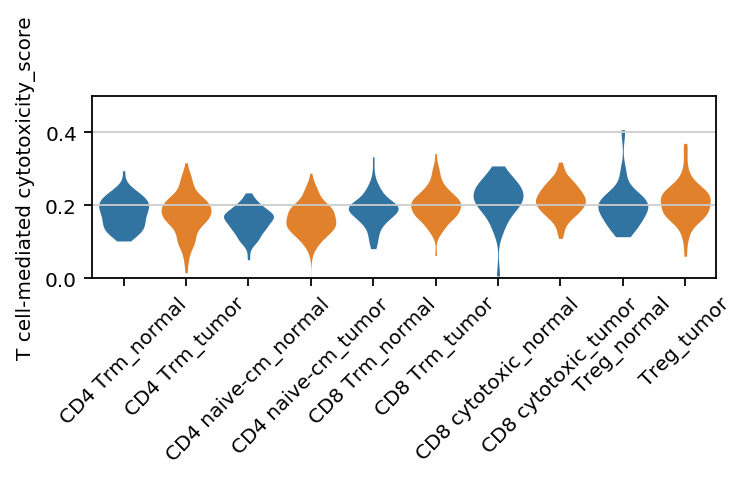

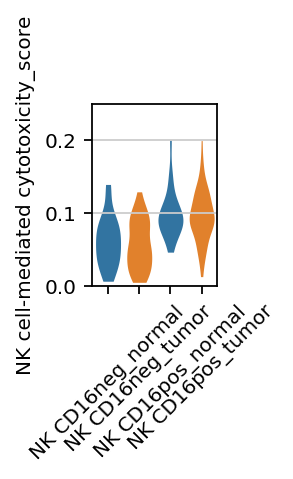

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(5,1.5))
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(adata[~adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg', 'B cell'])], ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity.pdf')
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])], ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity.pdf')

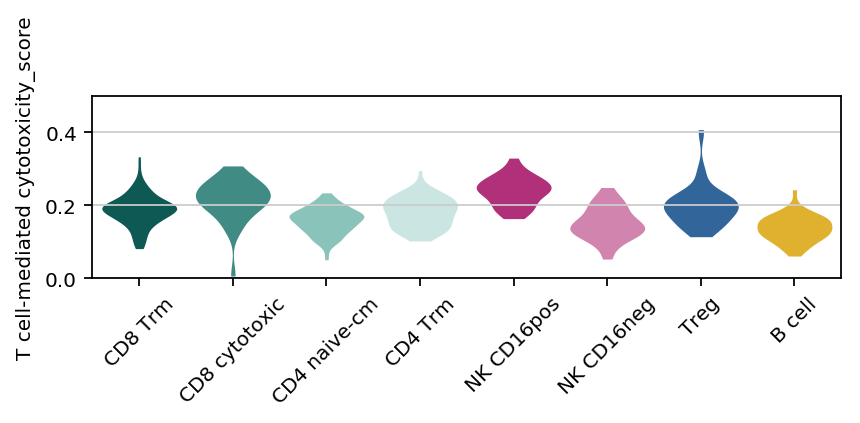

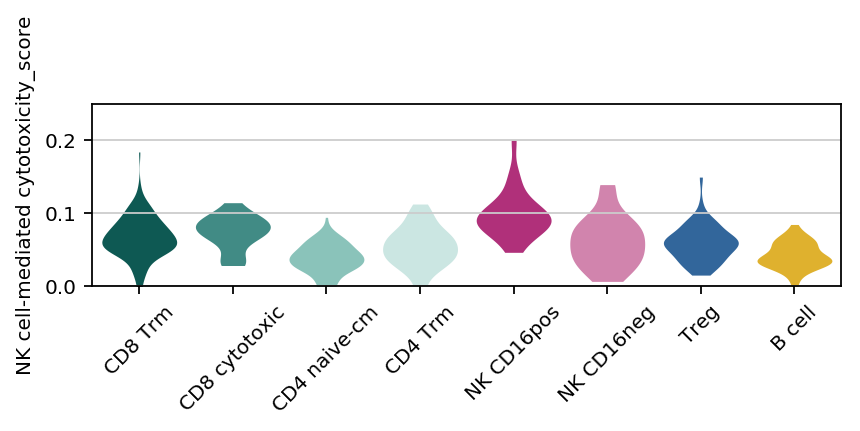

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(6,1.5))
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(ndata, ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity_normal.pdf')
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(ndata, ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity_normal.pdf')

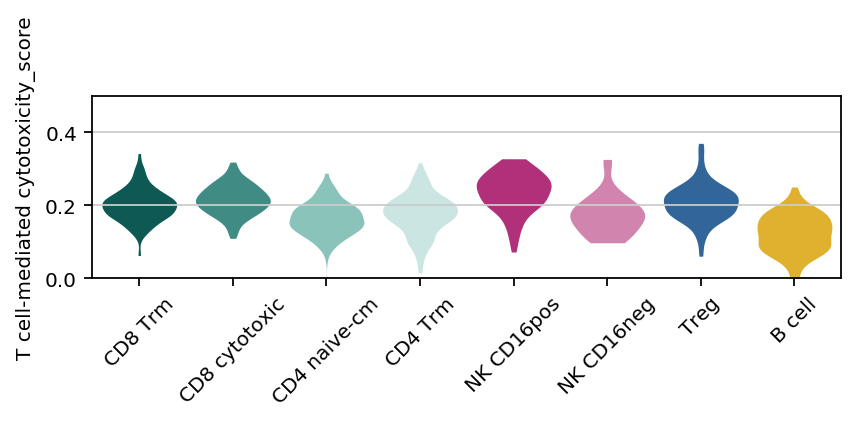

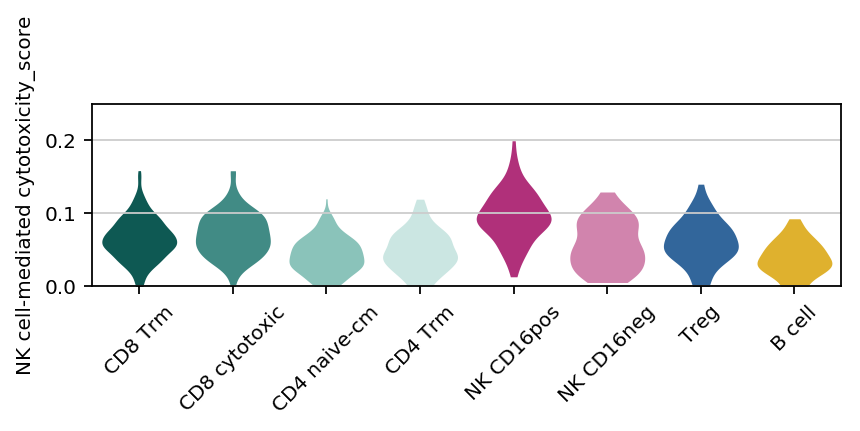

In [71]:
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(tdata, ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity_tumor.pdf')
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(tdata, ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity_tumor.pdf')

computing score 'K562_score'
    finished: added
    'K562_score', score of gene set (adata.obs) (0:00:00)
computing score 'ADCC_score'
    finished: added
    'ADCC_score', score of gene set (adata.obs) (0:00:00)
computing score 'cytokine_score'
    finished: added
    'cytokine_score', score of gene set (adata.obs) (0:00:00)
computing score 'common_score'
    finished: added
    'common_score', score of gene set (adata.obs) (0:00:00)


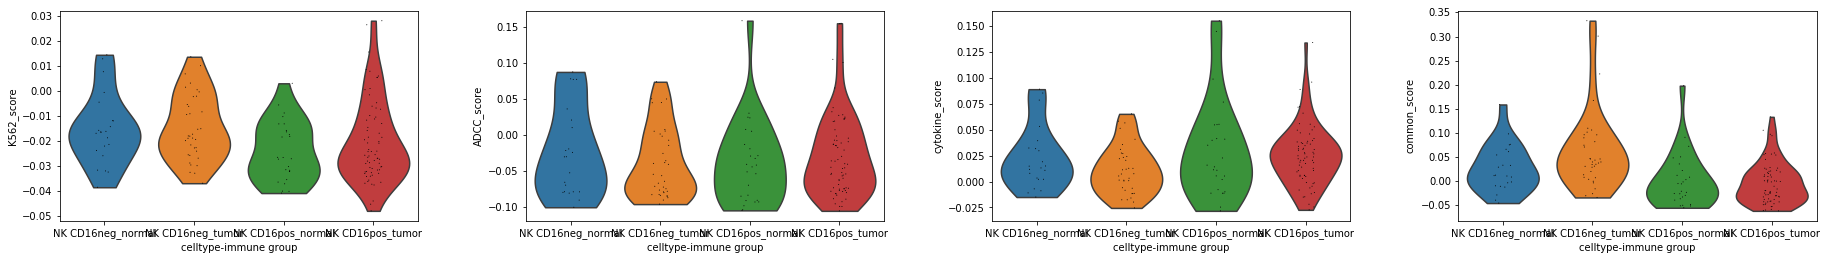

In [47]:
NKstim = {
    'K562':['ACSM3', 'ALDH1A2', 'ANLN', 'ANXA2', 'APOC1', 'ATP6V0A1', 'BCAT1', 'BUB1', 'CA8', 'CASC5', 'CCL22', 'CCNA2', 'CCNB1', 'CCNB2', 'CD86', 'CDC42BPA', 'CDC45', 'CDC6', 'CDK1', 'CENPN', 'CENPW', 'CFH', 'CKS1B', 'CKS2', 'CLIC2', 'CLIC4', 'CPED1', 'CYP51A1', 'DLGAP5', 'DSCR8', 'DSG2', 'DTL', 'EXO1', 'FAM72D', 'FN1', 'FOS', 'FOSB', 'GAGE1', 'GAGE10', 'GAGE12C', 'GAGE12F', 'GAGE12J', 'GAGE13', 'GAGE2A', 'GAGE2B', 'GAGE2D', 'GAGE2E', 'GAGE8', 'GALNT5', 'GRASP', 'GTSF1', 'GYPA', 'GYPE', 'HEMGN', 'HIST1H2AI', 'HIST1H3A', 'HIST1H3B', 'HIST1H3H', 'HMGCS1', 'HMMR', 'HSPA4L', 'IFI30', 'IL1B', 'INSIG1', 'KIAA0101', 'KIF14', 'KIF18A', 'LAPTM4B', 'LINC00515', 'MAGEC2', 'MAP1B', 'MLF1', 'MND1', 'MNS1', 'MPP1', 'MYL4', 'NCAPG', 'NDC80', 'NEK2', 'NET1', 'NMU', 'NR4A1', 'NR4A2', 'NUF2', 'NUSAP1', 'ORC1', 'PAGE1', 'PAGE2B', 'PAGE5', 'PAICS', 'PBK', 'PPA1', 'PRAME', 'PRC1', 'PRDX1', 'PRKAR2B', 'PRR11', 'PTTG1', 'RGS16', 'RHAG', 'RHOXF2B', 'RHOXF2B', 'SCG3', 'SGOL1', 'SLC27A2', 'SLC7A11', 'SQLE', 'SSX1', 'SSX2B', 'SSX2B', 'STIL', 'TFPI', 'TMEM88', 'TUBA1B', 'TXN', 'TYMS', 'UBE2T', 'VIM', 'ZNF280A'],
    'ADCC':['BCL2','GBE1','GPI','GPR18','GTSF1','HIST1H3B','IGF2R','OSBPL3','SNORD12C','TPI1','TSPAN7'],
    'cytokine':['AGK','AHR','ARHGAP31','ATP8B4','B4GALT5','BATF','C4orf32','CCND2','CCR1','CD274','CD44','CD97','CDK6','CMAHP','DDX21','DENND4A','FURIN','GADD45B','GZMB','HAPLN3','HAVCR2','HK2','HUWE1','ICAM1','IFNG','IL12RB2','IL18R1','IL26','IL4R','IRF8','ITGA1','KCNA3','KIF3B','LINC00515','MAML2','MAP3K8','MDFIC','METTL1','MFSD2A','MIR147B','MIR4772','MT2A','MTHFD2','NABP1','NDFIP2','NFAT5','NFKB1','NFKBIA','P2RX5','PIM1','PIM2','PUS7','RCN1P2','RGS16','RNU12','SLAMF7','SLC27A2','SLC7A5','SMS','SNORD1A','SOCS2','SOD2','TMEM88','TNFAIP8'],
    'common':[ 'BCL2A1', 'CCL3', 'CCL3L3', 'CCL3L1', 'CCL3L3', 'CCR7', 'CD83', 'CRTAM', 'CSF2', 'CXCL9', 'EGR2', 'HILPDA', 'IL21R', 'IL2RA', 'IRF4', 'KDM6B', 'LYZ', 'MIR155', 'NR4A3', 'SDC4', 'STARD4', 'TNFRSF9', 'TRAF1', 'XCL1', 'XCL2']}
for gs in NKstim:
    sc.tl.score_genes(adata, NKstim[gs], score_name = str(gs)+'_score', use_raw=True)
sc.pl.violin(adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])], [str(gs)+'_score' for gs in NKstim], groupby = 'celltype-immune_group')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype-immune_group' as categorical


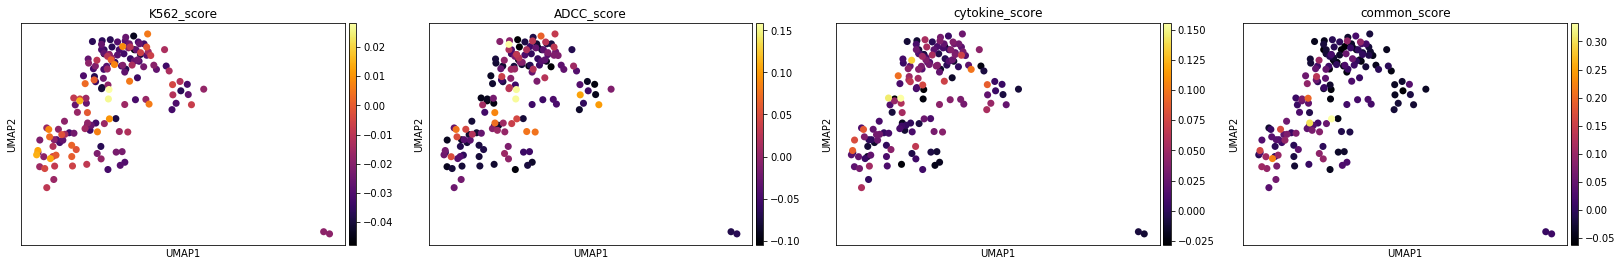

In [27]:
sc.pl.umap(adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])], color = [str(gs)+'_score' for gs in NKstim], color_map = 'inferno', size = 200)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1, max_out_group_fraction: 0.5


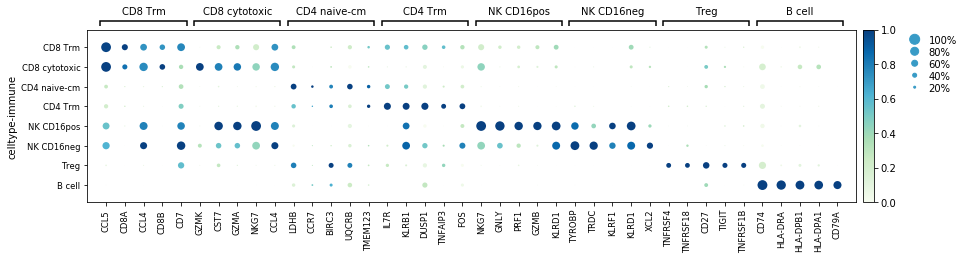

In [2]:
sc.tl.rank_genes_groups(adata, groupby = 'celltype-immune', method = 'wilcoxon', n_genes=30000)
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)
sc.pl.rank_genes_groups_dotplot(adata, 
                                key='rank_genes_groups_filtered', 
                                n_genes = 5, 
                                standard_scale = 'var', 
                                dendrogram=False,
                                color_map = 'GnBu', 
                                var_group_rotation = 0,
                                save = '/lymphoid_rank_gene_dotplot.pdf')

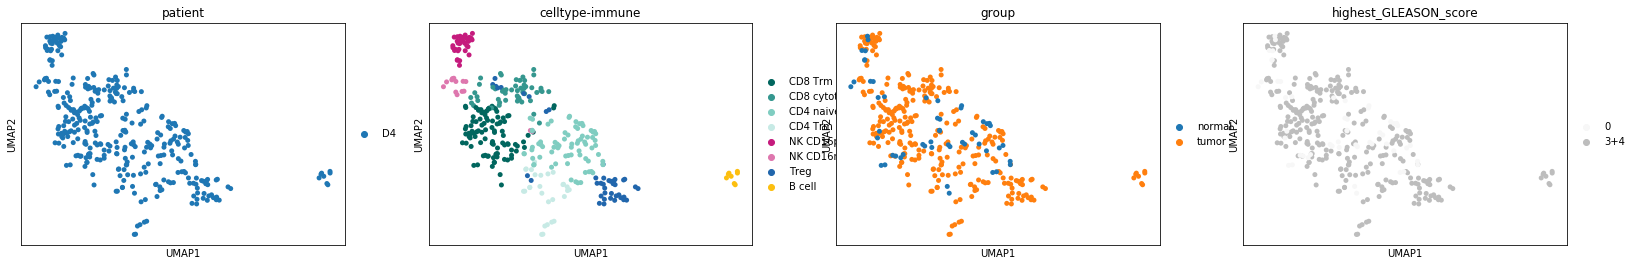

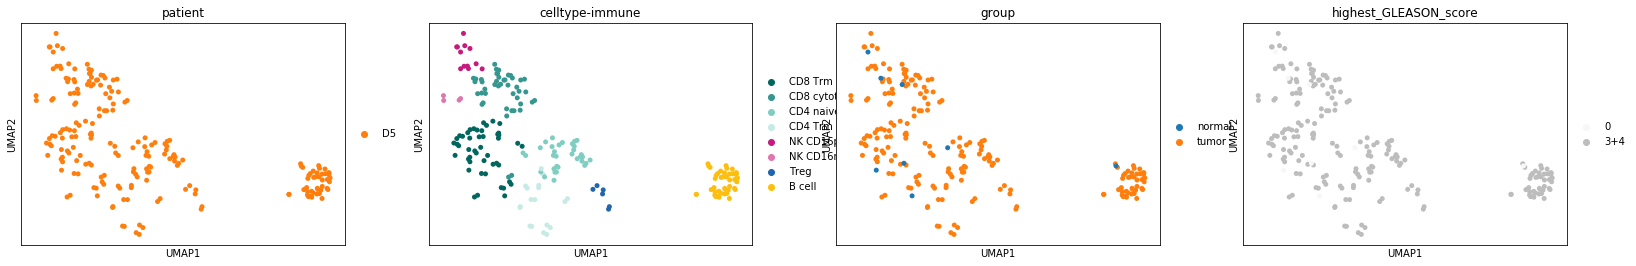

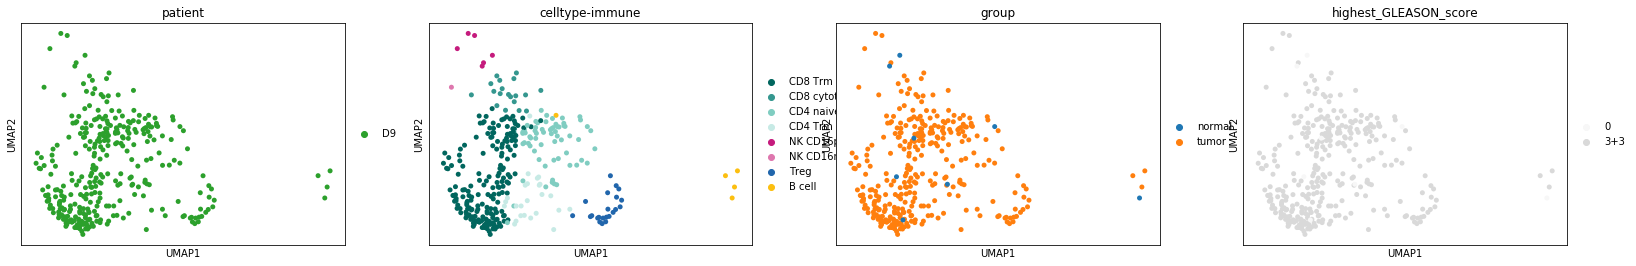

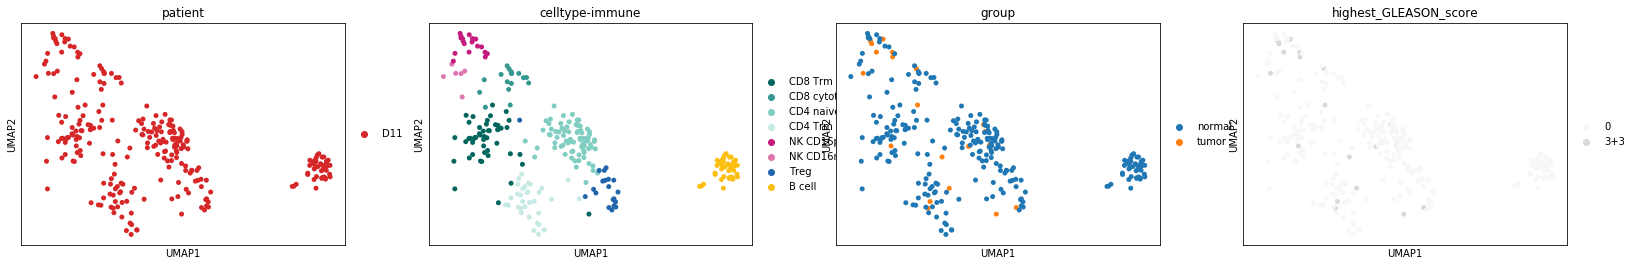

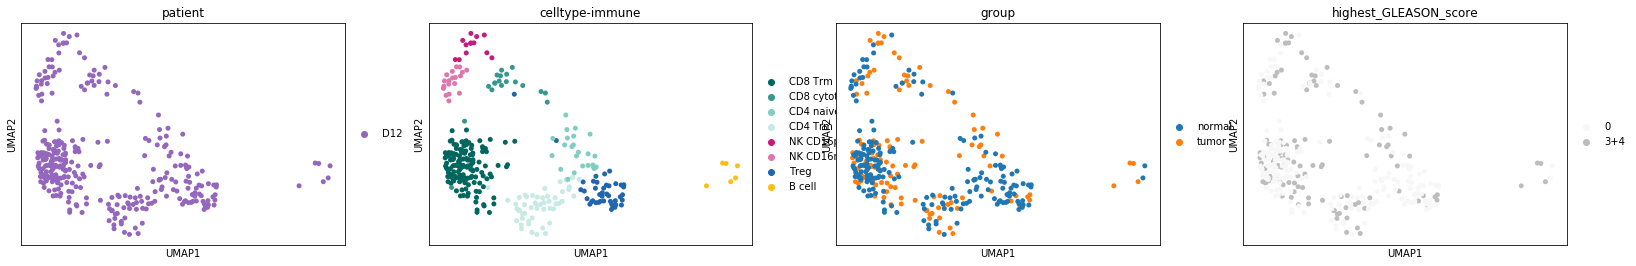

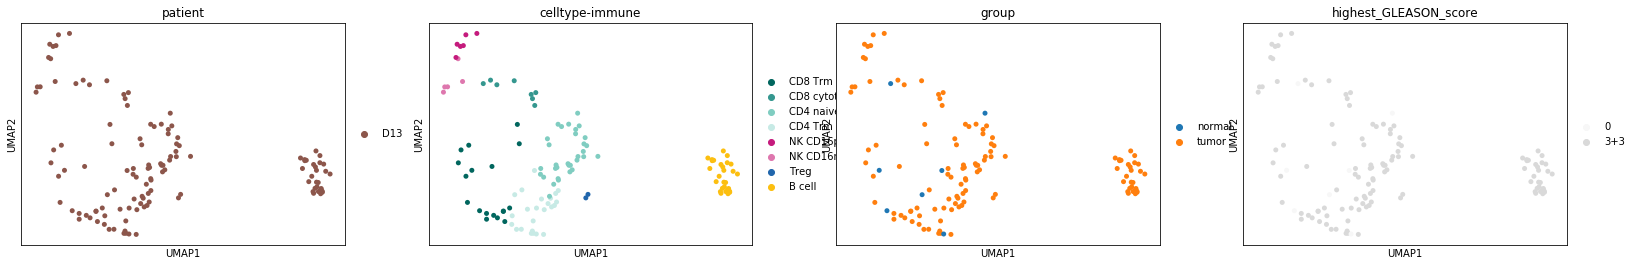

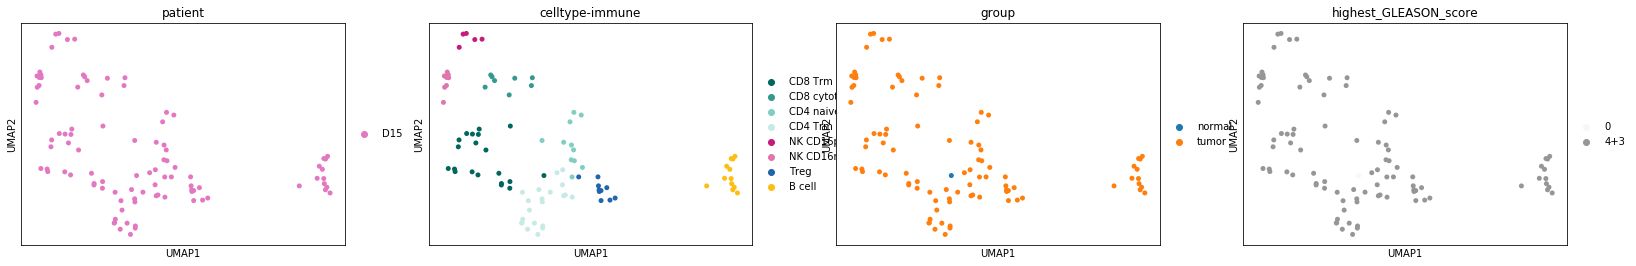

In [46]:
for p in ['D4', 'D5', 'D9', 'D11', 'D12', 'D13', 'D15']:
    sc.pl.umap(adata[adata.obs['patient']==p], color = ['patient', 'celltype-immune', 'group', 'highest_GLEASON_score'], size = 100)

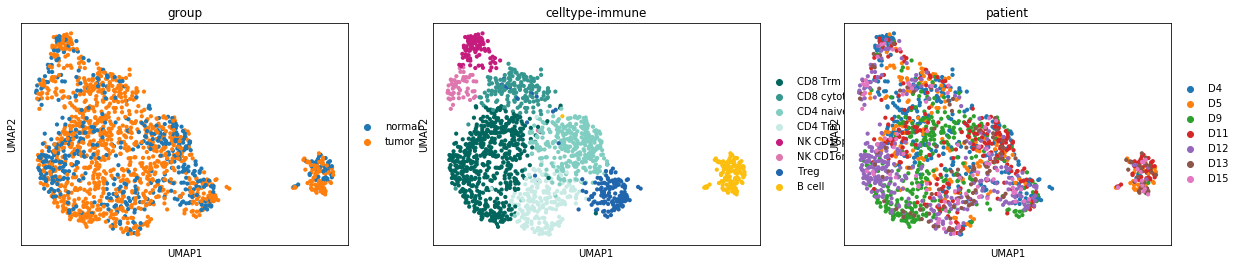

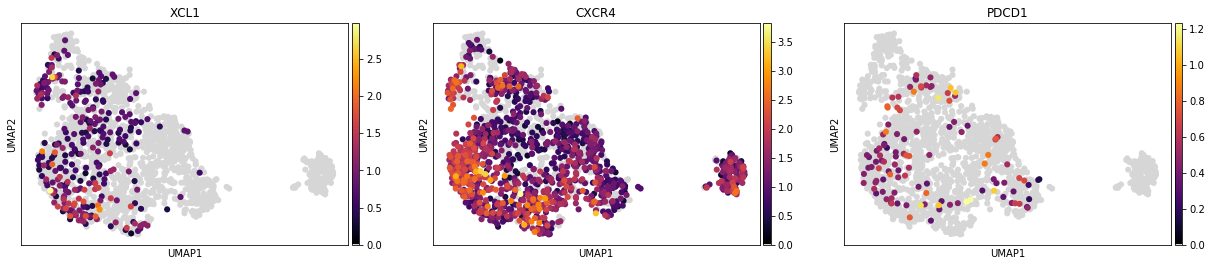

In [48]:
sc.pl.umap(adata, color = ['group','celltype-immune','patient'], color_map = newcmp)
sc.pl.umap(adata, color = ['XCL1','CXCR4', 'PDCD1'], color_map = newcmp, size = 150)

In [3]:
# save
results_file = 'out/lymphoid.h5ad'
# save this file
adata.write(results_file, compression = 'gzip')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

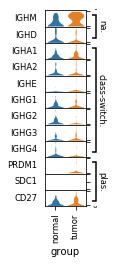

In [2]:
bdata = adata[adata.obs['celltype'] == 'B cell']
sc.pl.stacked_violin(bdata, 
              {'naive':['IGHM', 'IGHD'], 
               'class-switched':['IGHA1', 'IGHA2', 'IGHE', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'],
               'plasma cell':['PRDM1', 'SDC1', 'CD27']},
              groupby = 'group',
              standard_scale = 'var',
              swap_axes = True,
              color_map = 'viridis',
              var_group_rotation = 0,
              linewidth = 0,
              save = '/immunogobulins_Bcell normal tumor.pdf',
              palette = bdata.uns['group_colors'])

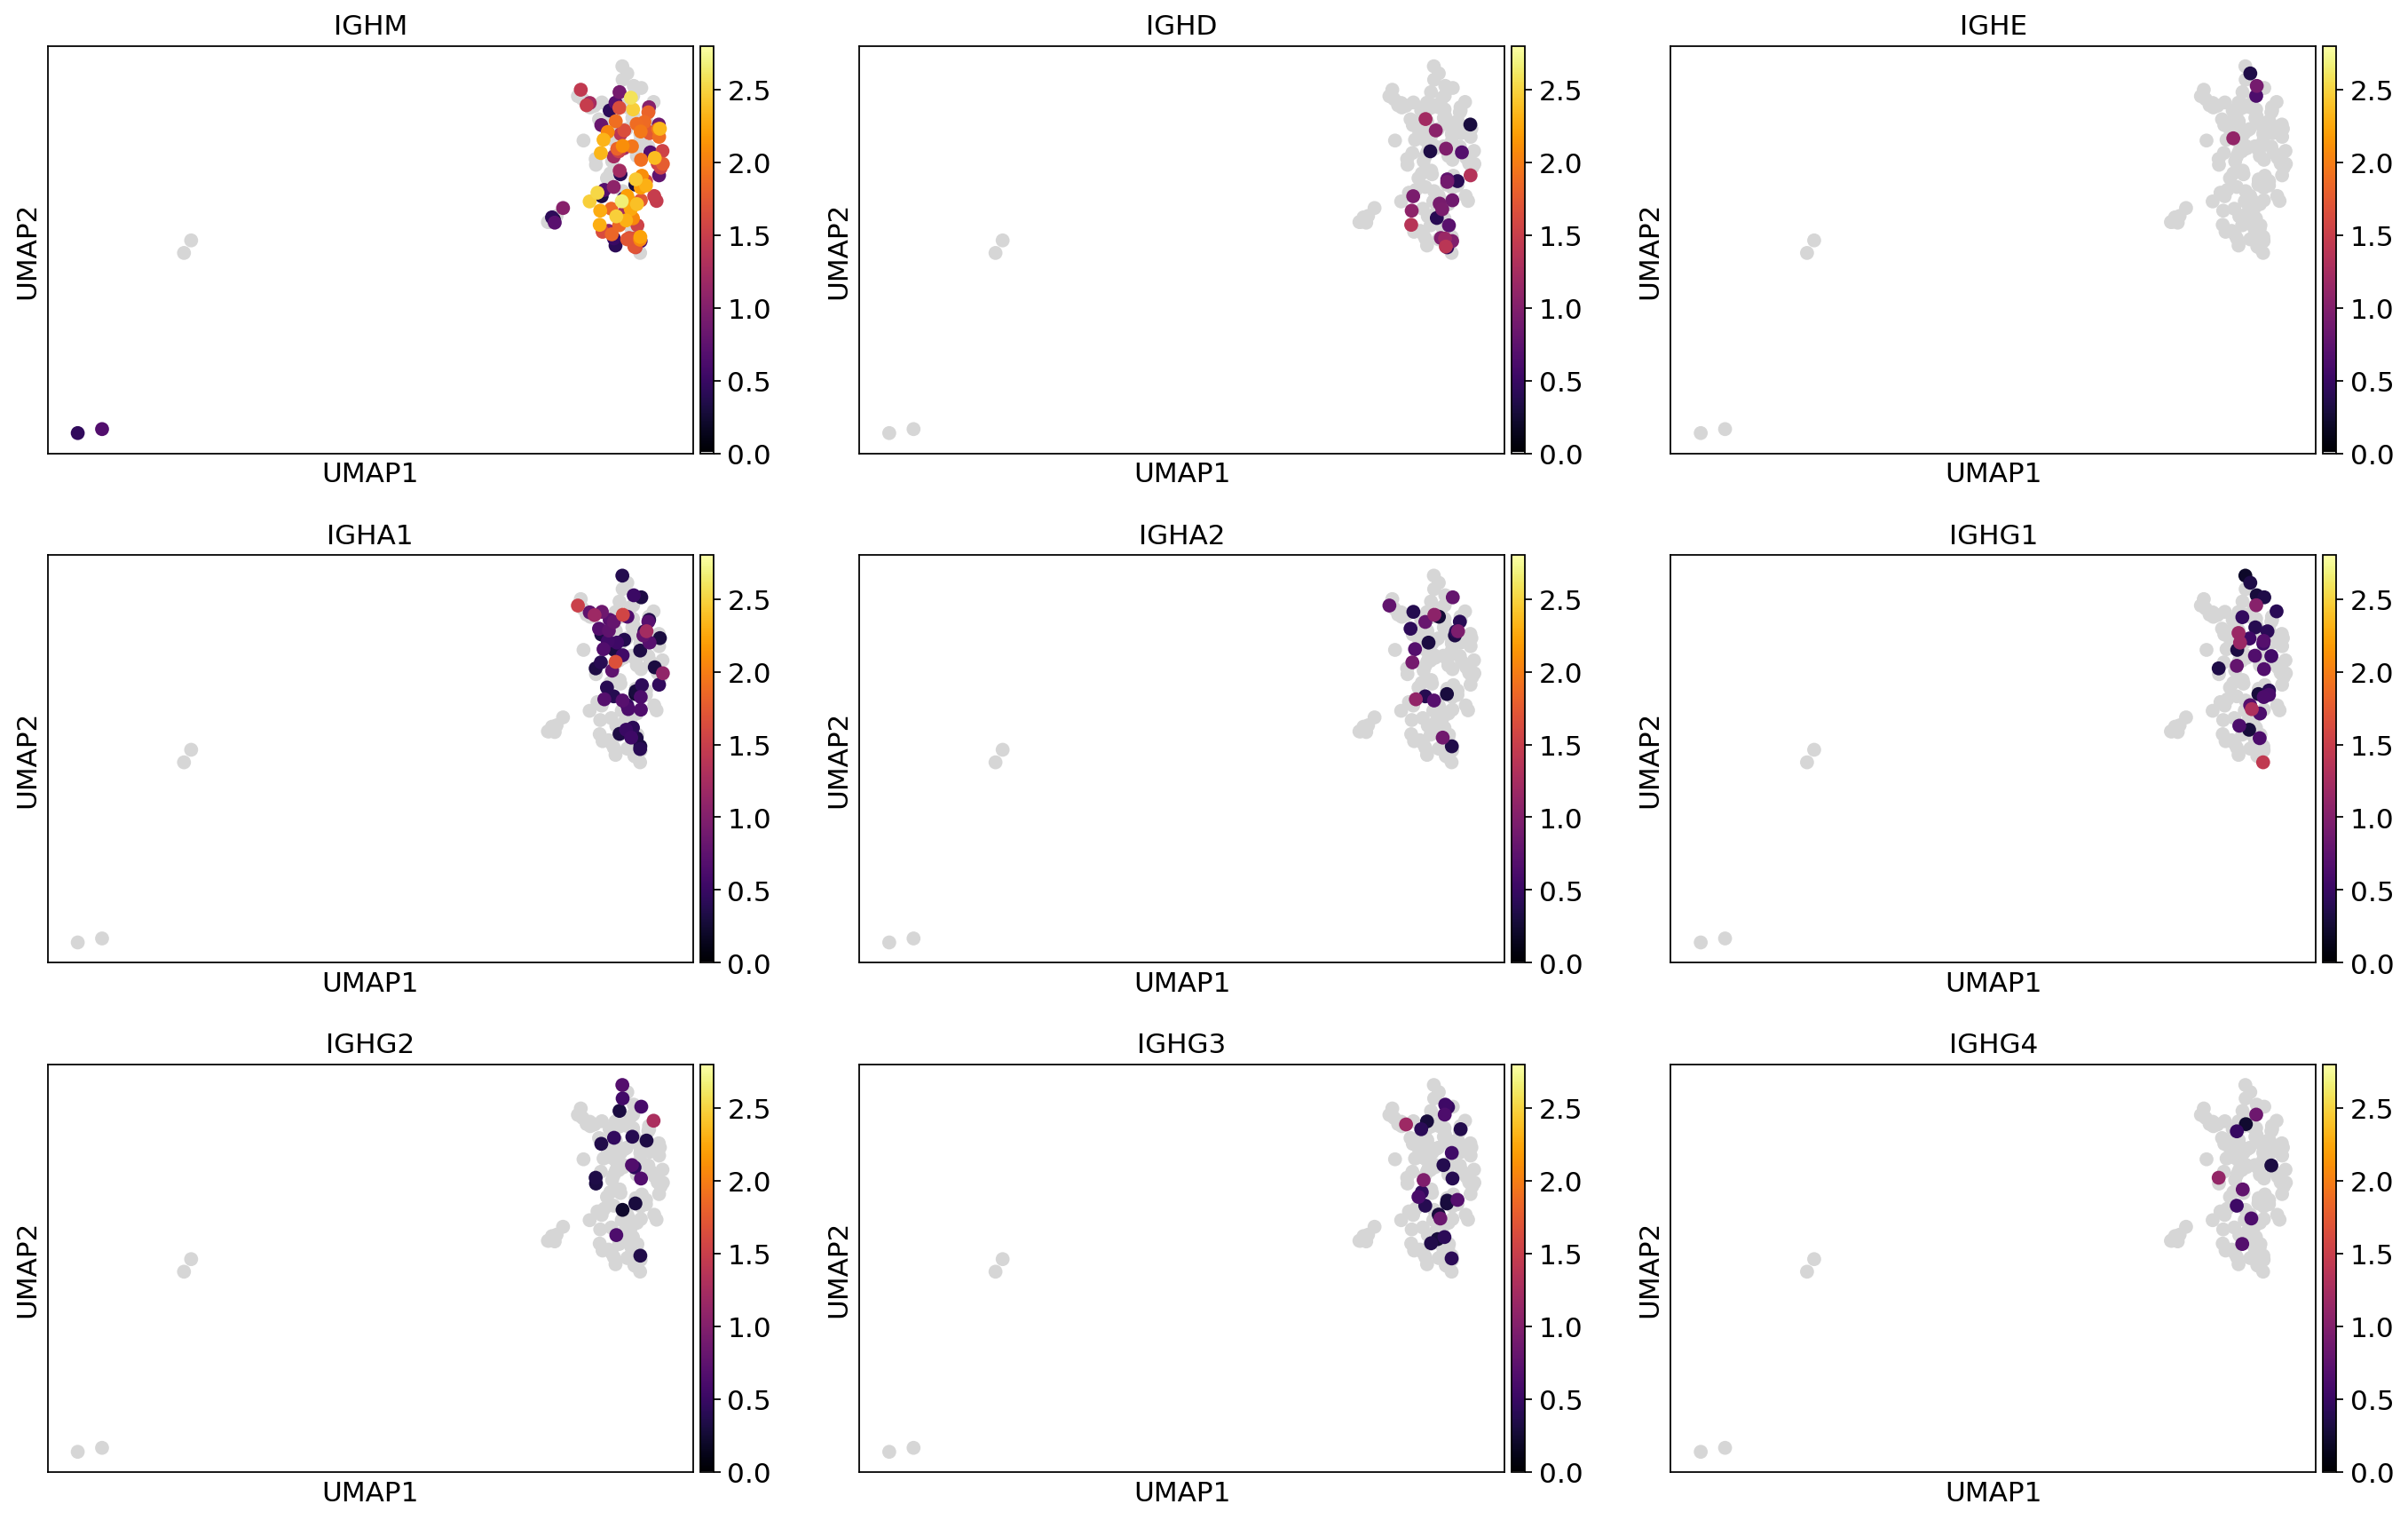

In [8]:
bdata = adata[adata.obs['celltype'] == 'B cell']
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.umap(bdata, color = ['IGHM', 'IGHD', 'IGHE', 'IGHA1', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Bcell ImmunoGobulins.pdf')

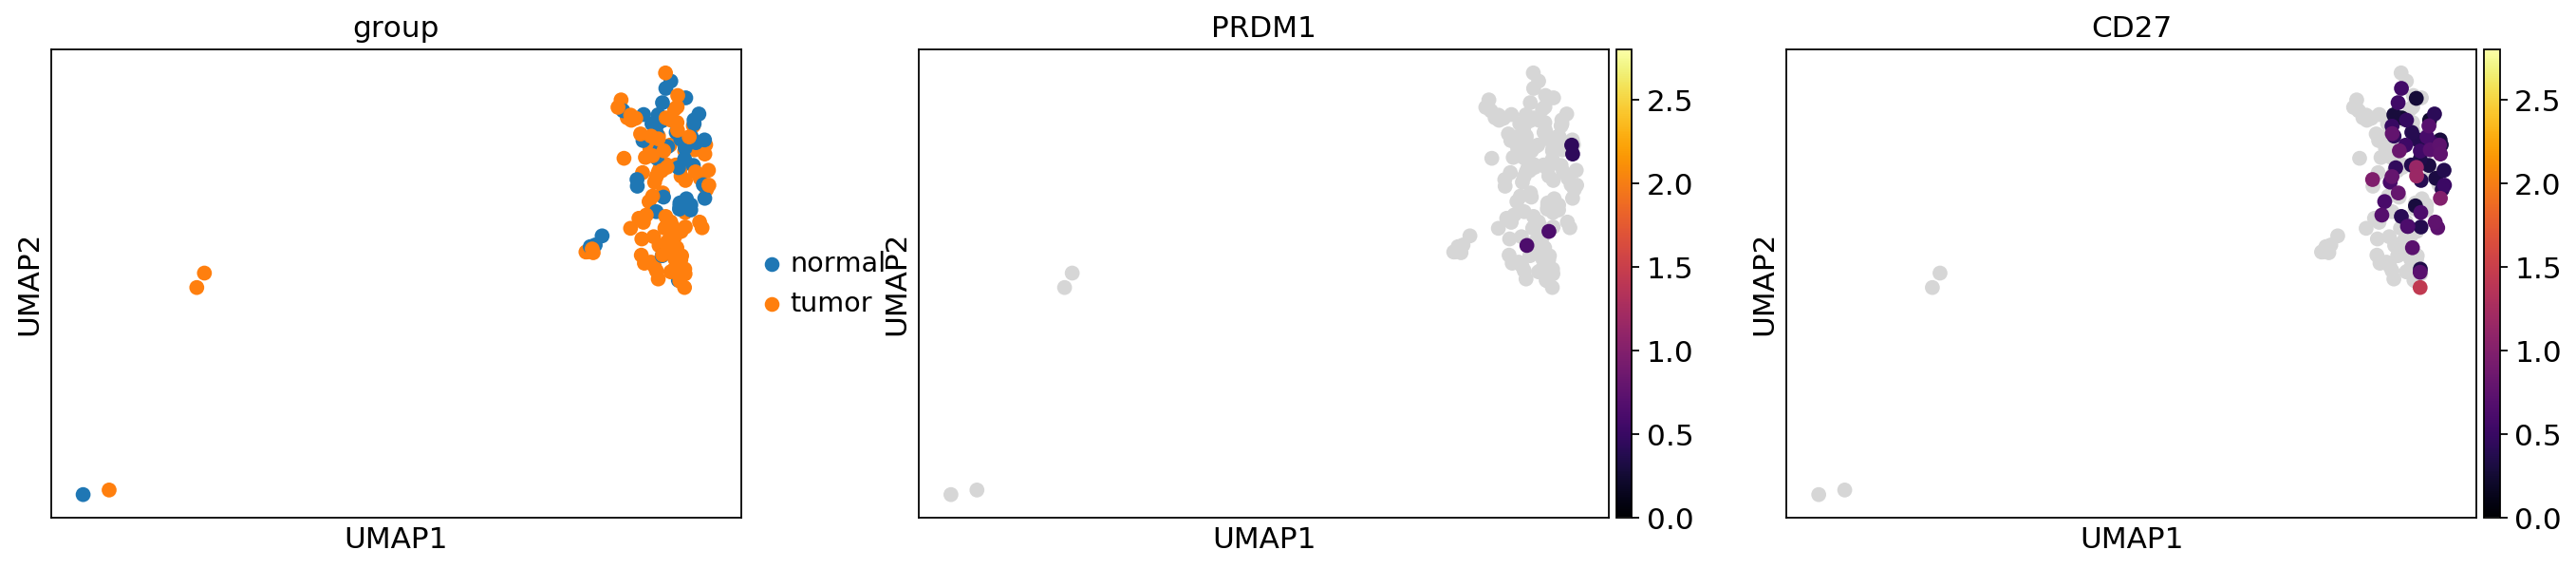

In [9]:
sc.pl.umap(bdata, color = ['group', 'PRDM1', 'CD27'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Bcell plasma.pdf')

In [14]:
module = ['MARCH1', 'MARCH8', 'ABCB9', 'ACE', 'ACTR10', 'ACTR1A', 'ACTR1B', 'AP1B1', 'AP1G1', 'AP1M1', 'AP1M2', 'AP1S1', 'AP1S2', 'AP1S3', 'AP2A1', 'AP2A2', 'AP2B1', 'AP2M1', 'AP2S1', 'AP3B1', 'AP3D1', 'ARF1', 'ATG5', 'AZGP1', 'B2M', 'BCAP31', 'CALR', 'CANX', 'CAPZA1', 'CAPZA2', 'CAPZA3', 'CAPZB', 'CCL19', 'CCL21', 'CCR7', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CD207', 'CD209', 'CD36', 'CD68', 'CD74', 'CD8A', 'CENPE', 'CHUK', 'CLEC4A', 'CLEC4M', 'CLTA', 'CLTC', 'CTSD', 'CTSE', 'CTSF', 'CTSH', 'CTSL', 'CTSS', 'CTSV', 'CYBA', 'CYBB', 'DCTN1', 'DCTN2', 'DCTN3', 'DCTN4', 'DCTN5', 'DCTN6', 'DNM2', 'DYNC1H1', 'DYNC1I1', 'DYNC1I2', 'DYNC1LI1', 'DYNC1LI2', 'DYNLL1', 'DYNLL2', 'E7ENX8', 'ERAP1', 'ERAP2', 'FCER1G', 'FCGR1A', 'FCGR1B', 'FCGR2B', 'FCGRT', 'FGL2', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'ICAM1', 'IDE', 'IFI30', 'IKBKB', 'IKBKG', 'ITGAV', 'ITGB5', 'KIF11', 'KIF15', 'KIF18A', 'KIF22', 'KIF23', 'KIF26A', 'KIF2A', 'KIF2B', 'KIF2C', 'KIF3A', 'KIF3B', 'KIF3C', 'KIF4A', 'KIF4B', 'KIF5A', 'KIFAP3', 'KLC1', 'KLC2', 'LAG3', 'LGMN', 'LILRB2', 'LNPEP', 'MICA', 'MICB', 'MR1', 'NCF1', 'NCF2', 'NCF4', 'NOD1', 'NOD2', 'OSBPL1A', 'PDIA3', 'PSAP', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB10', 'PSMB11', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSME1', 'PSME2', 'PSME3', 'PSME4', 'PSMF1', 'PYCARD', 'RAB10', 'RAB27A', 'RAB32', 'RAB33A', 'RAB34', 'RAB35', 'RAB3B', 'RAB3C', 'RAB4A', 'RAB5B', 'RAB6A', 'RAB7A', 'RAB8B', 'RACGAP1', 'RELB', 'RFTN1', 'RILP', 'SAR1B', 'SEC13', 'SEC22B', 'SEC23A', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SH3GL2', 'SLC11A1', 'SNAP23', 'SPTBN2', 'TAP1', 'TAP2', 'TAPBP', 'TAPBPL', 'THBS1', 'TRAF6', 'TREM2', 'TREX1', 'VAMP3', 'VAMP8', 'WAS', 'YTHDF1']
sc.tl.score_genes(bdata, module, score_name = 'Antigen processing and presentation_score', use_raw=True)

computing score 'Antigen processing and presentation_score'
    finished: added
    'Antigen processing and presentation_score', score of gene set (adata.obs) (0:00:00)


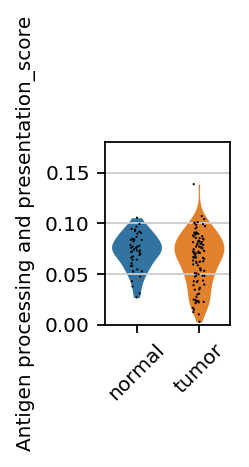

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
ax = sns.violinplot()
sc.pl.violin(bdata, ['Antigen processing and presentation_score'], ax = ax, groupby = 'group', size = 1, standard_scale = 'var', linewidth = 0, rotation = 45, save = '/B cell_Antigen processing and presentation_score.pdf')
bdata.obs[['group','Antigen processing and presentation_score']].to_csv('figures/violin/Antigen processing and presentation_score.csv')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata
# try gene set test with Wherry exhaustion genesets
genesets = pd.read_csv('dataset/Mouse_exhaustion_genesets_converted.txt', sep = '\t')
for gs in genesets.columns:
    sc.tl.score_genes(adata, [g for g in genesets[gs] if g is not np.nan], score_name = str(gs)+'_score', use_raw=True)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1
computing score 'GSE41867 Chronic-acute CD8+ Up_score'
    finished: added
    'GSE41867 Chronic-acute CD8+ Up_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE41870 CD8+ LCMV Chronic-Acute UP_score'
    finished: added
    'GSE41870 CD8+ LCMV Chronic-Acute UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score'
    finished: added
    'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', score of gene set (adata.obs) (0:00:00)


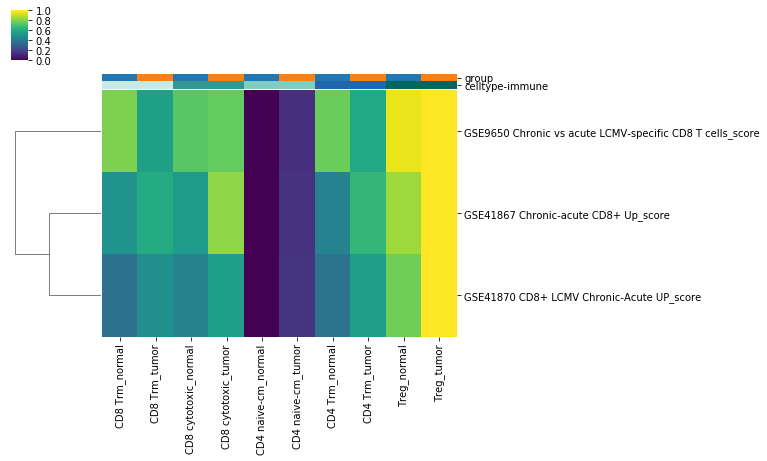

In [2]:
adata = adata[~adata.obs['leiden'].isin(['2,0','2,1', '4'])]
# calculate average enrichment score
list1 = list(set(adata.obs['celltype-immune']))
subset = adata.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in genesets.columns]]
outputN = pd.DataFrame()
outputT = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictN = {}
    outdictT = {}
    for k in [str(m)+'_score' for m in genesets.columns]:
        outN = {k:np.mean(subsetN[k])}
        outT = {k:np.mean(subsetT[k])}
        outdictN.update(outN)
        outdictT.update(outT)
    outputN = outputN.append(outdictN, ignore_index=True)
    outputT = outputT.append(outdictT, ignore_index=True)
outputN.index = [l+'_normal' for l in list1]
outputT.index = [l+'_tumor' for l in list1]

output = pd.concat([outputN, outputT])

import itertools
col_colors1 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(itertools.chain.from_iterable(itertools.repeat(x, len(list1)) for x in adata.uns['group_colors']))))))
col_colors2 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(list(adata.uns['celltype-immune_colors']) + list(adata.uns['celltype-immune_colors']))))))
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
col_colors.index = [l + '_normal' for l in list1] + [l + '_tumor' for l in list1]
col_colors.columns = ['group', 'celltype-immune']

output = output.transpose()

import matplotlib.pyplot as plt
g = sns.clustermap(output[['CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 cytotoxic_normal', 'CD8 cytotoxic_tumor', 'CD4 naive-cm_normal', 'CD4 naive-cm_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor']], col_colors = col_colors, col_cluster=False, standard_scale = 0, cmap="viridis", figsize=(8, 6))
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Wherry_ex_geneset_score_split.pdf')

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

# transfer these slots to a raw object
adata_raw = sc.read_h5ad('out/prostate_raw.h5ad')
adata_raw = adata_raw[(adata_raw.obs['celltype'].isin(['Tcell', 'Bcell', 'NKcell'])) & ~(adata.obs['patient'].isin(['D7','D6','D14']))]
adata_raw.obs = adata.obs
adata_raw.obs['cohort'] = 'UCAM'
adata_raw.obsm = adata.obsm
adata_raw.uns = adata.uns

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
# save
adata_raw.write('out/lymphoid_raw.h5ad', compression = 'gzip')

... storing 'cohort' as categorical


In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


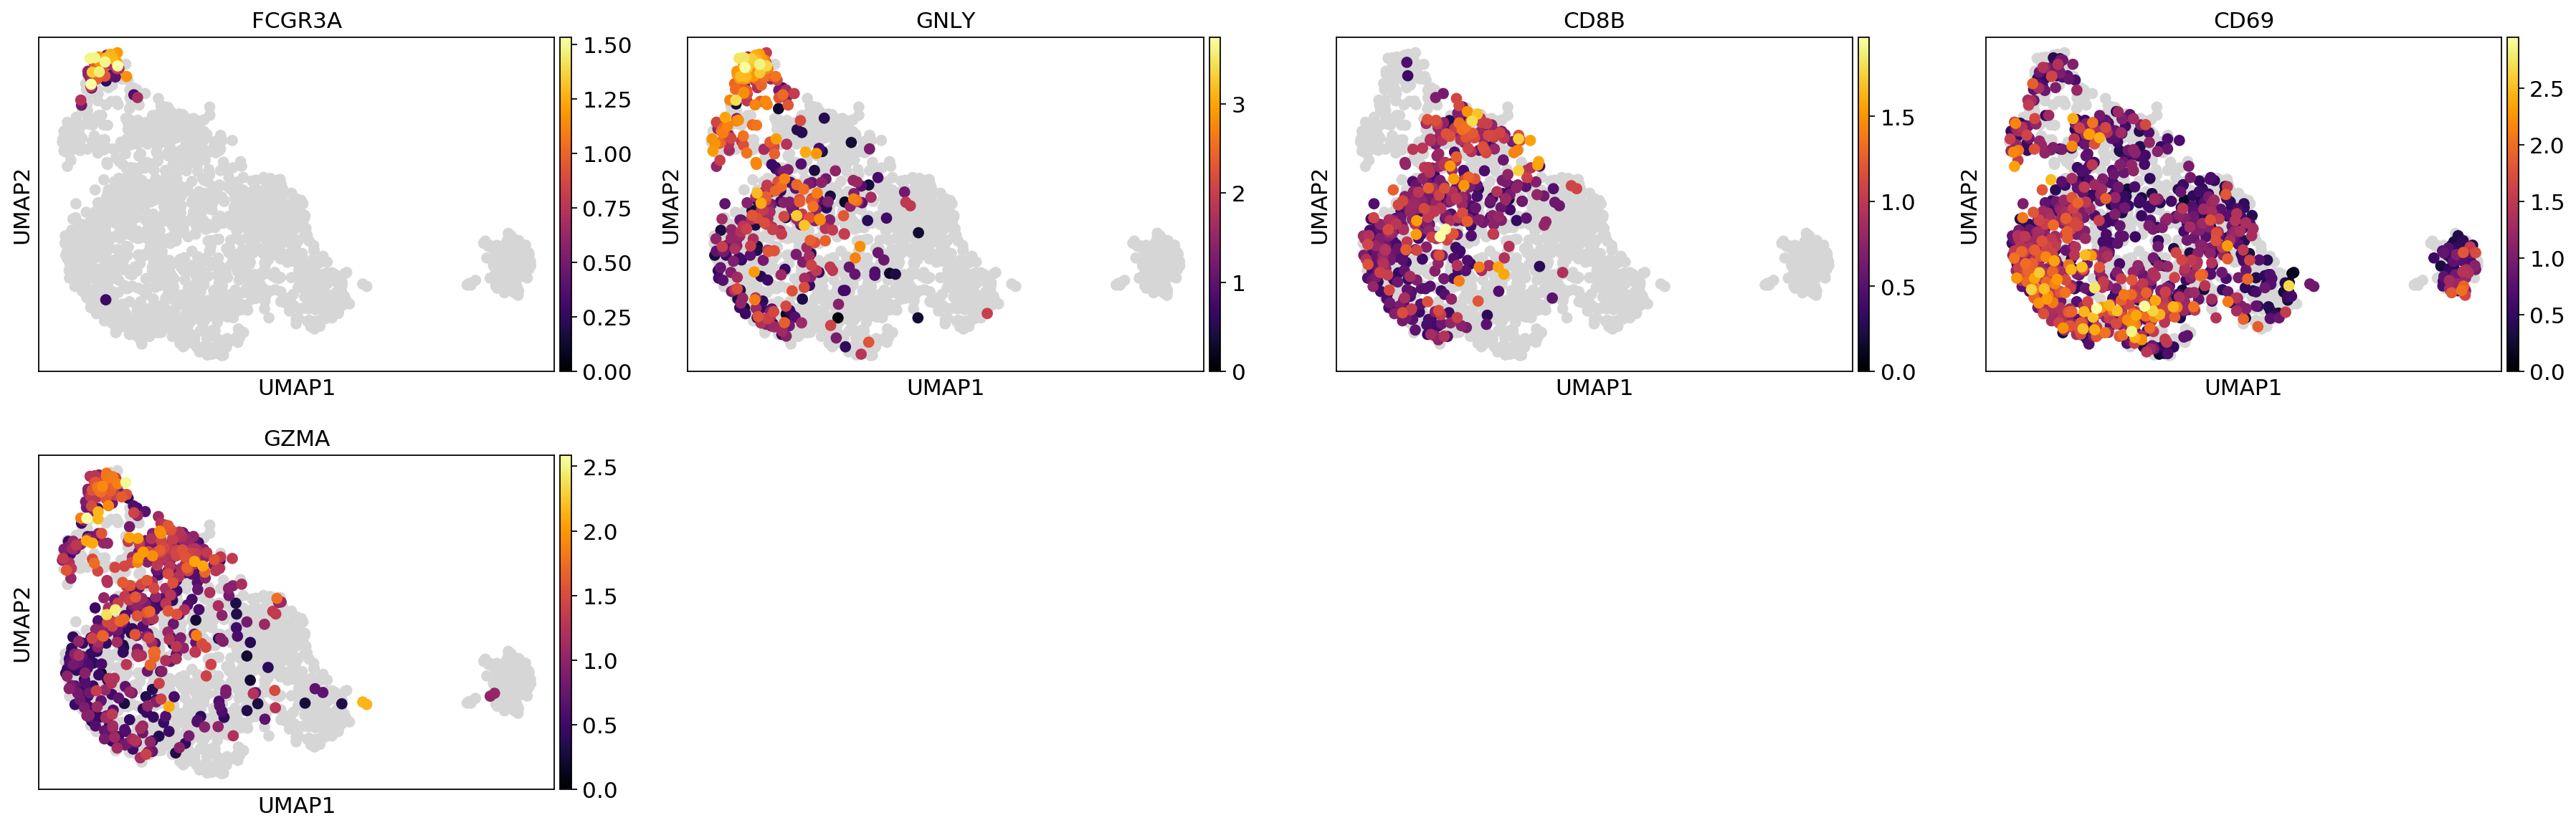

In [11]:
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.umap(adata, color = ['FCGR3A', 'GNLY', 'CD8B', 'CD69', 'GZMA'], size =200, color_map = newcmp, save = '/lymphoid_markers.pdf')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [2]:
adata

AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

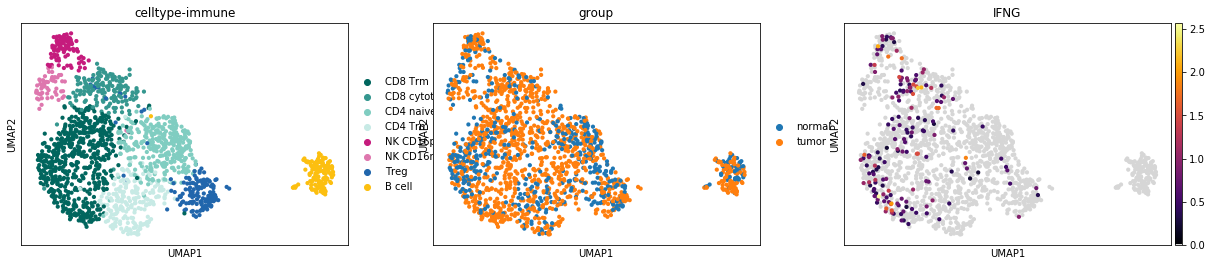

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)
sc.pl.umap(adata, color = ['celltype-immune', 'group','IFNG'], color_map = newcmp)

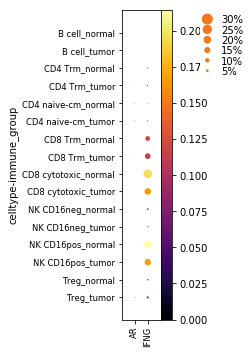

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [3]:
sc.pl.dotplot(adata, ['AR', 'IFNG'], groupby = 'celltype-immune_group', color_map = 'inferno')

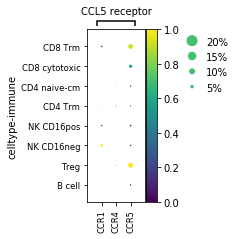

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[1.0499999999999998, 0, 0.2, 0.5, 0.25])

In [10]:
sc.pl.dotplot(adata, {'CCL5 receptor':['CCR1', 'CCR4', 'CCR5']}, groupby = 'celltype-immune', color_map = 'viridis', standard_scale = 'var', var_group_rotation = 0)

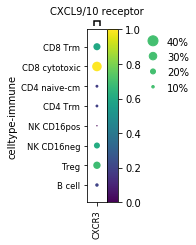

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[0.35, 0, 0.2, 0.5, 0.25])

In [3]:
sc.pl.dotplot(adata, {'CXCL9/10 receptor':['CXCR3']}, groupby = 'celltype-immune', color_map = 'viridis', standard_scale = 'var', var_group_rotation = 0, save = '/cxcr3_receptordotplot.pdf')

In [68]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [69]:
# subset to only normal
adata = adata[adata.obs['group'] == 'normal']
adata

View of AnnData object with n_obs × n_vars = 523 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors',

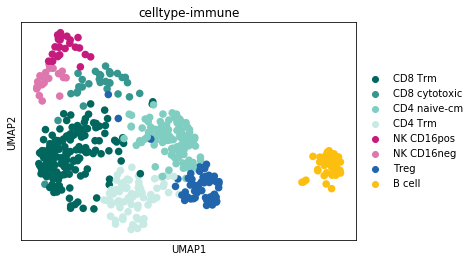

In [70]:
sc.pl.umap(adata, color = ['celltype-immune'])

In [71]:
adata.uns['celltype-immune_colors']

['#01665e',
 '#35978f',
 '#80cdc1',
 '#c7eae5',
 '#c51b7d',
 '#de77ae',
 '#2166ac',
 '#fcbf10']

In [4]:
# subset to just NK cells
adata = adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])]
adata

View of AnnData object with n_obs × n_vars = 48 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 

In [5]:
## recreate the data but trim away genes that are not expressed
adata = sc.AnnData(X = adata.raw.X, obs = adata.obs, var = adata.raw.var, uns = adata.uns, obsm = adata.obsm)

In [6]:
sc.pp.filter_genes(adata, min_cells = 3)
adata.raw = adata

filtered out 17576 genes that are detected in less than 3 cells


In [7]:
# scale the entire data
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value = 10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [8]:
sc.tl.rank_genes_groups(adata, groupby = 'celltype-immune', method = 'wilcoxon', n_genes=30000, use_raw = True, pts = True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [10]:
import sys
sys.path.append('/home/jovyan/NC_study/scanpy/scripts')
from tools import returnDEres,exportDEres

In [76]:
exportDEres(adata, key = 'rank_genes_groups', column = 'NK CD16pos', filename = 'out/DEG/NKCD16posvsneg.txt')
exportDEres(adata, key = 'rank_genes_groups', column = 'NK CD16neg', filename = 'out/DEG/NKCD16negvspos.txt')

In [17]:
dat = returnDEres(adata, key = 'rank_genes_groups', column = 'NK CD16pos')

In [54]:
filtereddat = dat[(dat['pvals'] < 0.05)]

In [55]:
filtereddat['filter'] = [(x > 0.25) | (x < -0.25) for x in filtereddat['logfoldchanges']]

In [56]:
filtereddat = filtereddat[filtereddat['filter']]
filtereddat

scores  logfoldchanges         pvals  pvals_adj  filter
NKG7    5.421206        1.976688  5.919850e-08   0.000259    True
B2M     4.469391        0.846043  7.844274e-06   0.017175    True
EMP3    4.272820        2.925965  1.930160e-05   0.028174    True
ARPC2   3.972792        1.875397  7.103516e-05   0.051844    True
FGFBP2  3.869334       29.725298  1.091332e-04   0.053099    True
...          ...             ...           ...        ...     ...
ELF1   -3.083052       -3.340937  2.048894e-03   0.289423    True
CXCR4  -3.186510       -2.600217  1.440005e-03   0.252231    True
RGS1   -3.414118       -4.043737  6.398888e-04   0.155671    True
BTG1   -3.538268       -1.868561  4.027616e-04   0.135669    True
TRDC   -3.910717       -2.071804  9.202260e-05   0.053099    True

[114 rows x 5 columns]

In [57]:
# remove mito and ribo
filtereddat = filtereddat[~filtereddat.index.isin(list(filtereddat.filter(regex='^RPL|^RPS|^MRPS|^MRPL|^MT-', axis = 0).index))]

In [72]:
filtereddat.to_csv('out/DEG/nk_markers.csv')

In [117]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [118]:
# subset to just NK cells
adata = adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])]
adata

View of AnnData object with n_obs × n_vars = 152 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors',

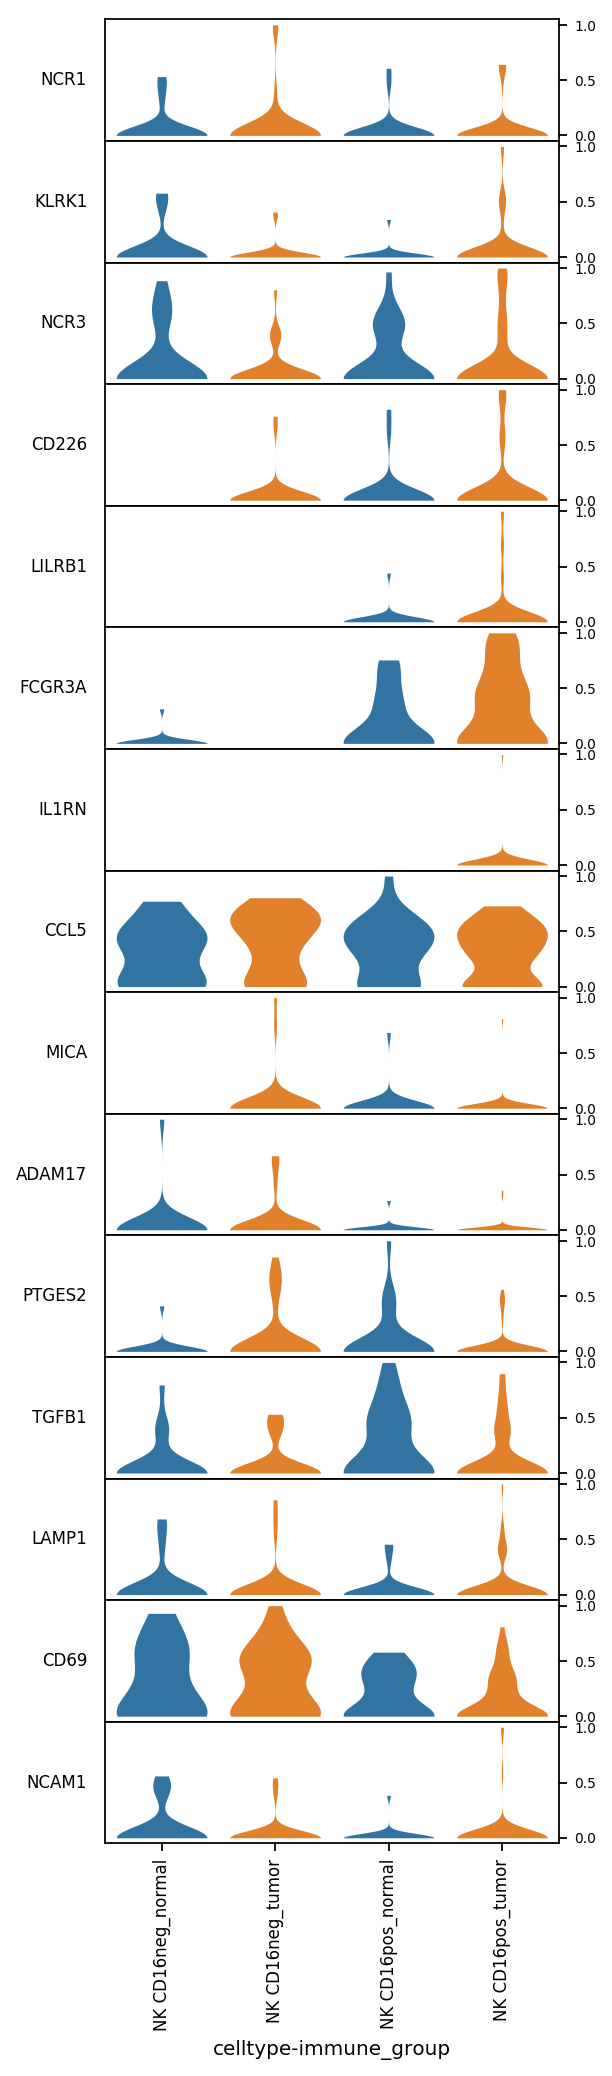

In [119]:
sc.pl.stacked_violin(adata, ['NCR1', 'KLRK1', 'NCR3', 'CD226', 'LILRB1', 'FCGR3A', 'IL1RN',  'CCL5', 'MICA', 'ADAM17', 'PTGES2', 'TGFB1', 'LAMP1', 'CD69', 'NCAM1'], 
                     groupby = 'celltype-immune_group', 
                     standard_scale = 'var', 
                     swap_axes = True,
                     linewidth = 0,
                     figsize = (4, 15),
                     palette = adata.uns['group_colors'])

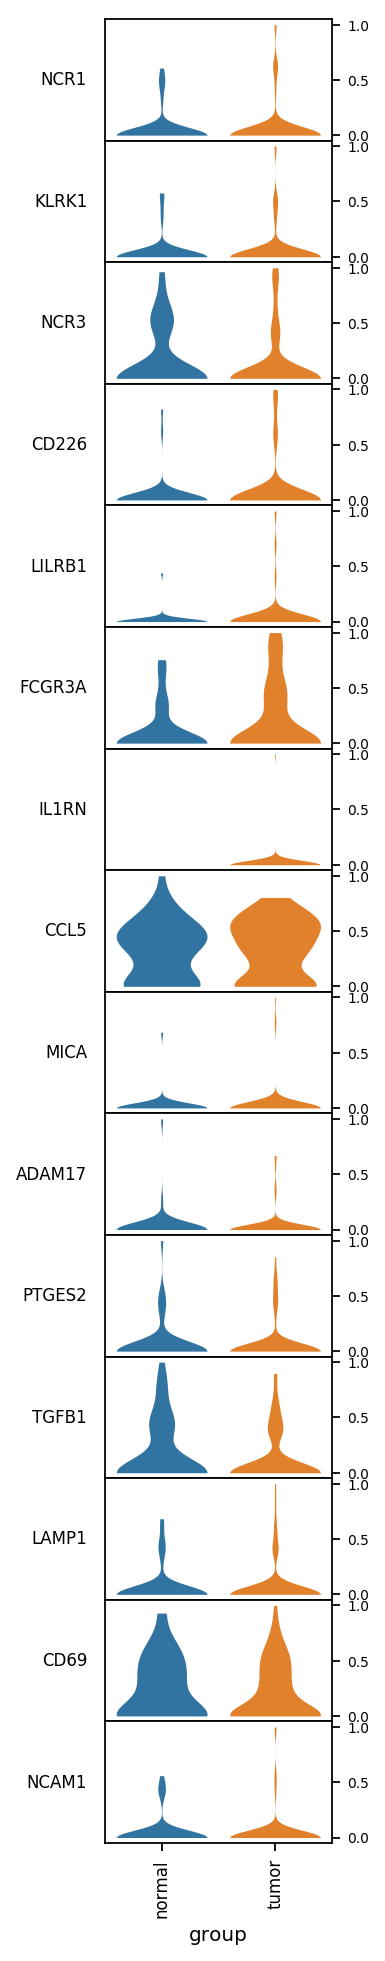

In [134]:
sc.pl.stacked_violin(adata, ['NCR1', 'KLRK1', 'NCR3', 'CD226', 'LILRB1', 'FCGR3A', 'IL1RN',  'CCL5', 'MICA', 'ADAM17', 'PTGES2', 'TGFB1', 'LAMP1', 'CD69', 'NCAM1'], 
                     groupby = 'group', 
                     standard_scale = 'var', 
                     swap_axes = True,
                     linewidth = 0,
                     figsize = (2, 15),
                     palette = adata.uns['group_colors'])

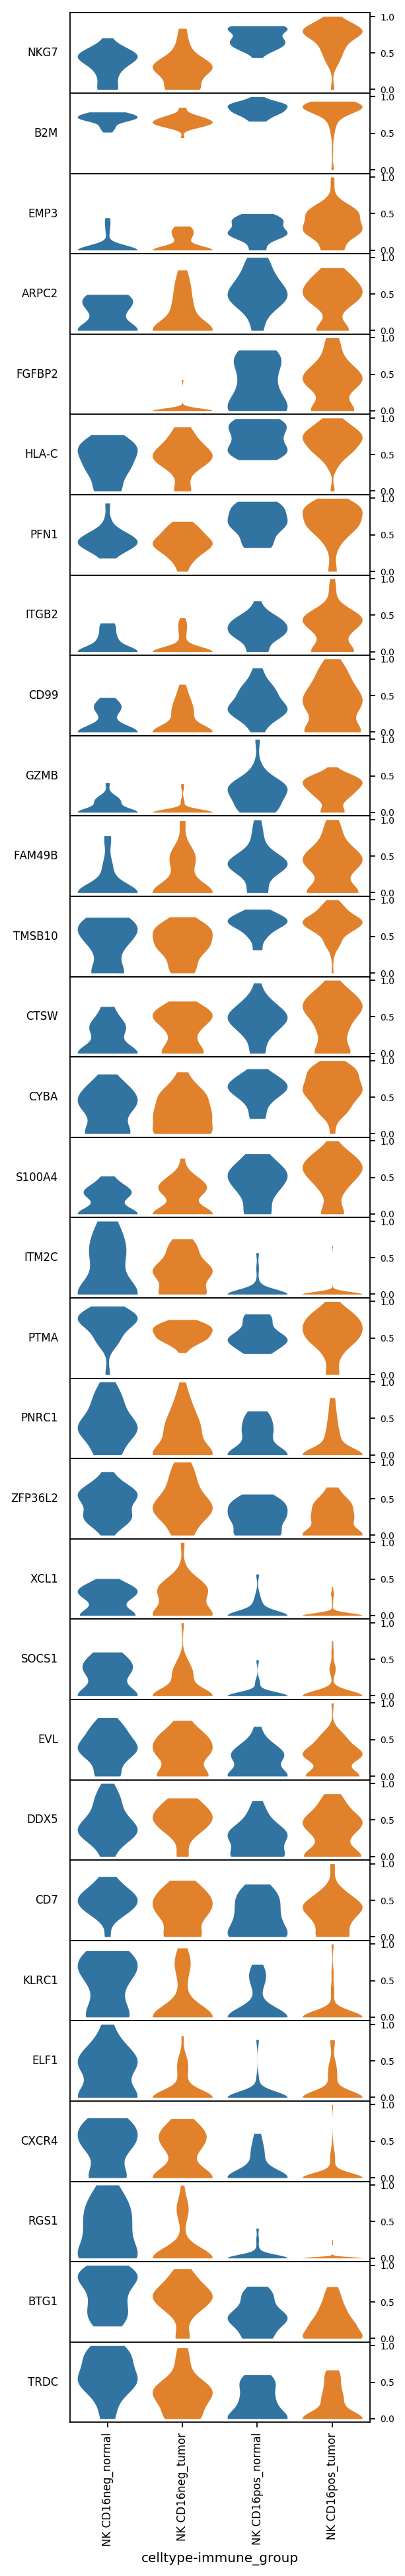

In [120]:
sc.pl.stacked_violin(adata, ['NKG7', 'B2M', 'EMP3', 'ARPC2', 'FGFBP2', 'HLA-C', 'PFN1', 'ITGB2', 'CD99', 'GZMB', 'FAM49B', 'TMSB10', 'CTSW', 'CYBA', 'S100A4', 'ITM2C', 'PTMA', 'PNRC1', 'ZFP36L2', 'XCL1', 'SOCS1', 'EVL', 'DDX5', 'CD7', 'KLRC1', 'ELF1', 'CXCR4', 'RGS1', 'BTG1', 'TRDC'],
                     groupby = 'celltype-immune_group', 
                     standard_scale = 'var', 
                     swap_axes = True,
                     linewidth = 0,
                     figsize = (4, 30),
                     palette = adata.uns['group_colors'])

In [121]:
pos = adata[adata.obs['celltype-immune'] == 'NK CD16pos']
neg = adata[adata.obs['celltype-immune'] == 'NK CD16neg']

In [122]:
sc.tl.rank_genes_groups(pos, groupby = 'group', method = 'wilcoxon', n_genes = 30000)
sc.tl.rank_genes_groups(neg, groupby = 'group', method = 'wilcoxon', n_genes = 30000)
sc.tl.rank_genes_groups(adata, groupby = 'group', method = 'wilcoxon', n_genes = 30000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [123]:
import sys
sys.path.append('/home/jovyan/NC_study/scanpy/scripts')
from tools import returnDEres,exportDEres

In [124]:
posde = returnDEres(pos, 'rank_genes_groups', 'tumor')
negde = returnDEres(neg, 'rank_genes_groups', 'tumor')
adatade = returnDEres(adata, 'rank_genes_groups', 'tumor')

In [125]:
adatade

scores  logfoldchanges         pvals  pvals_adj
TXNIP   3.444510        1.170107  5.720964e-04   1.000000
CHST12  2.909402        1.344026  3.621213e-03   1.000000
FKBP8   2.881655        2.253055  3.955922e-03   1.000000
GNLY    2.762743        0.947006  5.731798e-03   1.000000
CD3E    2.501134        1.857039  1.237963e-02   1.000000
...          ...             ...           ...        ...
GPSM3  -2.933184       -1.127638  3.355048e-03   1.000000
COX5B  -3.095698       -0.998292  1.963499e-03   1.000000
EIF3G  -3.151191       -1.324033  1.626060e-03   1.000000
KLK3   -3.321633       -1.911912  8.949234e-04   1.000000
MSMB   -6.036810       -3.466199  1.571904e-09   0.000035

[21761 rows x 4 columns]

In [126]:
nk_aucellscores = pd.read_csv('dataset/NK_geneset_AUCELL_scores.csv', index_col = 0)
nk_aucellscores

GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                                     0.024446   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                                     0.018116   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                                     0.017744   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                                     0.036457   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                                     0.011174   
...                                                                                   ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                                     0.021347   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                                     0.019500   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA                                     0.016738   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA                                     0.027856   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC                                     0.029122   

                                              GSE13229_IMM_VS_MATURE_NKCELL_DN  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                          0.054434   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                          0.069979   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                          0.035452   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                          0.049283   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                          0.046365   
...                                                                        ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                          0.066812   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                          0.067325   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA                          0.072552   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA                          0.071644   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC                          0.068579   

                                              KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                                        0.158790   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                                        0.155560   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                                        0.067430   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                                        0.088581   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                                        0.119465   
...                                                                                      ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                                        0.100533   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                                        0.153528   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA                                        0.114551   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA                                        0.175827   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC                                        0.140488   

                                              GO_NATURAL_KILLER_CELL_ACTIVATION  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                           0.102234   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                           0.099012   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                           0.071412   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                           0.026451   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                           0.085417   
...                                                                         ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                           0.173404   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                           0.108434   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA

In [127]:
for i in nk_aucellscores.columns:
    adata.obs[i] = pd.Series(nk_aucellscores[i])

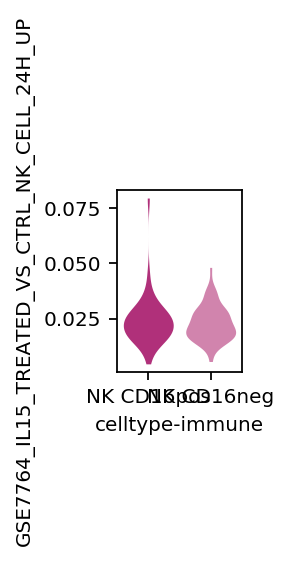

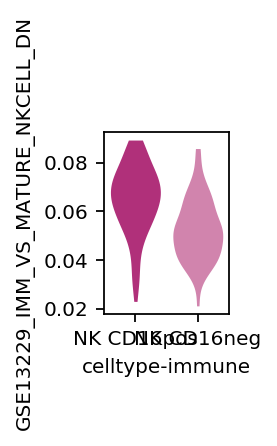

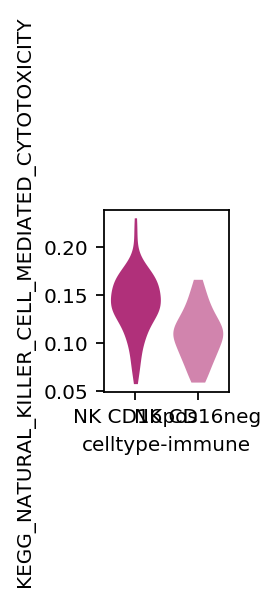

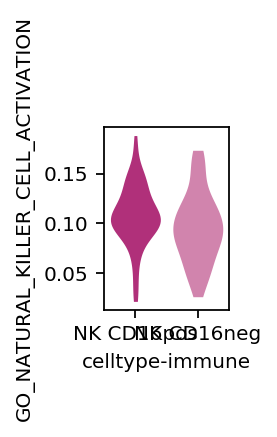

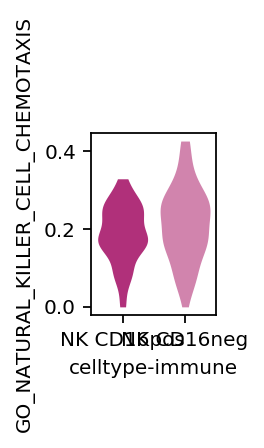

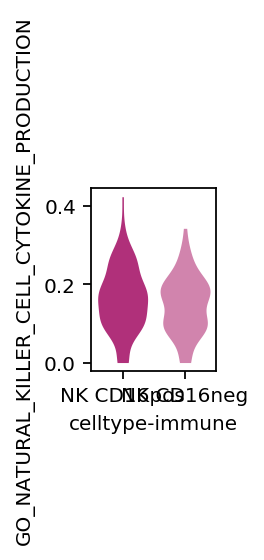

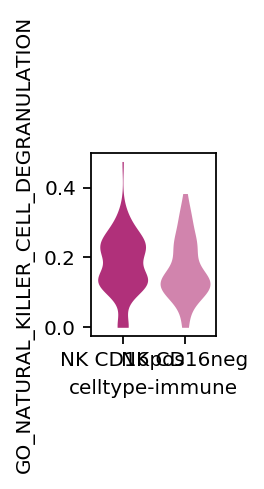

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
for i in nk_aucellscores.columns:
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(adata, [i], ax = ax, groupby = 'celltype-immune', linewidth = 0, size = 0, palette = adata.uns['celltype-immune_colors'], save = '/'+str(i)+'_NK_cell_AUCell.pdf')

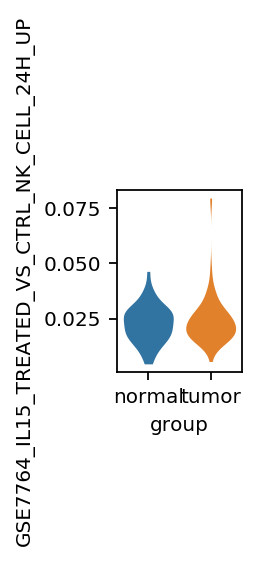

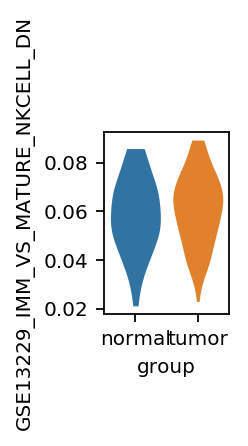

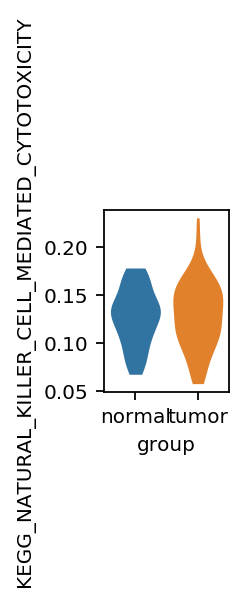

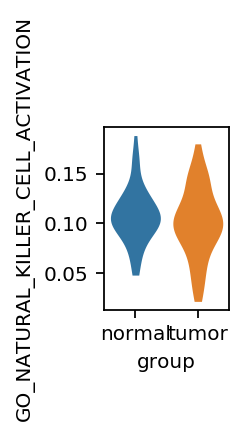

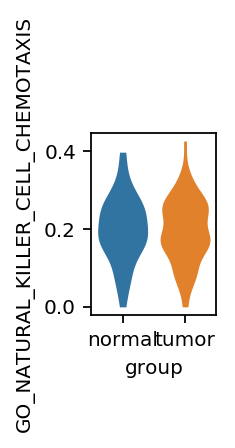

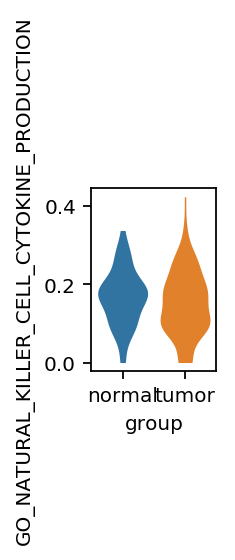

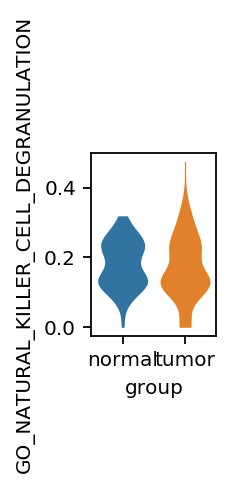

In [129]:
for i in nk_aucellscores.columns:
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(adata, [i], ax = ax, groupby = 'group', linewidth = 0, size = 0, palette = adata.uns['group_colors'], save = '/'+str(i)+'_NK_cell_all_AUCell.pdf')

In [130]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def geneset_ranksums(self, keys, column, groups, fdr = True):
    keys = list(keys)
    x = self.obs[self.obs[column] == groups[0]]
    y = self.obs[self.obs[column] == groups[1]]
    stats = []
    pvals = []
    for key in keys:
        res = ranksums(x[key], y[key])
        stats.append(res.statistic)
        pvals.append(res.pvalue)
    df = pd.DataFrame(zip(stats, pvals), columns = ['statistic', 'pvals'], index = keys)
    if fdr:
        df['bh_pvals'] = multipletests(df['pvals'], method = 'fdr_bh')[1]
        df['significant'] = df['bh_pvals'] < 0.05
    else:
        df['significant'] = df['pvals'] < 0.05
    return(df)

In [131]:
results = geneset_ranksums(adata, nk_aucellscores.columns, 'celltype-immune', ('NK CD16pos', 'NK CD16neg'))
results

statistic         pvals  \
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP      0.299636  7.644548e-01   
GSE13229_IMM_VS_MATURE_NKCELL_DN                 5.287249  1.241696e-07   
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY   5.932035  2.992021e-09   
GO_NATURAL_KILLER_CELL_ACTIVATION                2.416053  1.568979e-02   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS               -1.682134  9.254284e-02   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION       1.062001  2.882351e-01   
GO_NATURAL_KILLER_CELL_DEGRANULATION             1.378705  1.679857e-01   

                                                    bh_pvals  significant  
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP     7.644548e-01        False  
GSE13229_IMM_VS_MATURE_NKCELL_DN                4.345937e-07         True  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY  2.094415e-08         True  
GO_NATURAL_KILLER_CELL_ACTIVATION               3.660950e-02         True  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS               1.619500e-01        False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION      3.362743e-01        False  
GO_NATURAL_KILLER_CELL_DEGRANULATION            2.351800e-01        False

In [132]:
results = geneset_ranksums(adata, nk_aucellscores.columns, 'group', ('tumor', 'normal'))
results

statistic     pvals  bh_pvals  \
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP      0.057475  0.954167  0.954167   
GSE13229_IMM_VS_MATURE_NKCELL_DN                 0.794734  0.426768  0.746844   
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY   0.241790  0.808943  0.954167   
GO_NATURAL_KILLER_CELL_ACTIVATION               -1.078143  0.280970  0.746844   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS               -0.214043  0.830513  0.954167   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION      -1.234712  0.216938  0.746844   
GO_NATURAL_KILLER_CELL_DEGRANULATION            -0.826444  0.408552  0.746844   

                                                significant  
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP           False  
GSE13229_IMM_VS_MATURE_NKCELL_DN                      False  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY        False  
GO_NATURAL_KILLER_CELL_ACTIVATION                     False  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                     False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION            False  
GO_NATURAL_KILLER_CELL_DEGRANULATION                  False

In [107]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

In [112]:
bdata = adata[(adata.obs['celltype'] == 'B cell')]
bdata

View of AnnData object with n_obs × n_vars = 148 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors',

In [113]:
module = ['MARCH1', 'MARCH8', 'ABCB9', 'ACE', 'ACTR10', 'ACTR1A', 'ACTR1B', 'AP1B1', 'AP1G1', 'AP1M1', 'AP1M2', 'AP1S1', 'AP1S2', 'AP1S3', 'AP2A1', 'AP2A2', 'AP2B1', 'AP2M1', 'AP2S1', 'AP3B1', 'AP3D1', 'ARF1', 'ATG5', 'AZGP1', 'B2M', 'BCAP31', 'CALR', 'CANX', 'CAPZA1', 'CAPZA2', 'CAPZA3', 'CAPZB', 'CCL19', 'CCL21', 'CCR7', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CD207', 'CD209', 'CD36', 'CD68', 'CD74', 'CD8A', 'CENPE', 'CHUK', 'CLEC4A', 'CLEC4M', 'CLTA', 'CLTC', 'CTSD', 'CTSE', 'CTSF', 'CTSH', 'CTSL', 'CTSS', 'CTSV', 'CYBA', 'CYBB', 'DCTN1', 'DCTN2', 'DCTN3', 'DCTN4', 'DCTN5', 'DCTN6', 'DNM2', 'DYNC1H1', 'DYNC1I1', 'DYNC1I2', 'DYNC1LI1', 'DYNC1LI2', 'DYNLL1', 'DYNLL2', 'E7ENX8', 'ERAP1', 'ERAP2', 'FCER1G', 'FCGR1A', 'FCGR1B', 'FCGR2B', 'FCGRT', 'FGL2', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'ICAM1', 'IDE', 'IFI30', 'IKBKB', 'IKBKG', 'ITGAV', 'ITGB5', 'KIF11', 'KIF15', 'KIF18A', 'KIF22', 'KIF23', 'KIF26A', 'KIF2A', 'KIF2B', 'KIF2C', 'KIF3A', 'KIF3B', 'KIF3C', 'KIF4A', 'KIF4B', 'KIF5A', 'KIFAP3', 'KLC1', 'KLC2', 'LAG3', 'LGMN', 'LILRB2', 'LNPEP', 'MICA', 'MICB', 'MR1', 'NCF1', 'NCF2', 'NCF4', 'NOD1', 'NOD2', 'OSBPL1A', 'PDIA3', 'PSAP', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB10', 'PSMB11', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSME1', 'PSME2', 'PSME3', 'PSME4', 'PSMF1', 'PYCARD', 'RAB10', 'RAB27A', 'RAB32', 'RAB33A', 'RAB34', 'RAB35', 'RAB3B', 'RAB3C', 'RAB4A', 'RAB5B', 'RAB6A', 'RAB7A', 'RAB8B', 'RACGAP1', 'RELB', 'RFTN1', 'RILP', 'SAR1B', 'SEC13', 'SEC22B', 'SEC23A', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SH3GL2', 'SLC11A1', 'SNAP23', 'SPTBN2', 'TAP1', 'TAP2', 'TAPBP', 'TAPBPL', 'THBS1', 'TRAF6', 'TREM2', 'TREX1', 'VAMP3', 'VAMP8', 'WAS', 'YTHDF1']
sc.tl.score_genes(bdata, module, score_name = 'Antigen processing and presentation_score', use_raw=True)

computing score 'Antigen processing and presentation_score'


Trying to set attribute `.obs` of view, making a copy.


    finished: added
    'Antigen processing and presentation_score', score of gene set (adata.obs) (0:00:00)


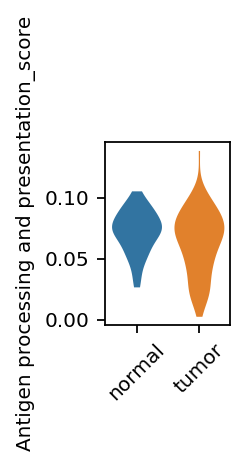

In [114]:
ax = sns.violinplot()
ax.grid(False)
sc.pl.violin(bdata, ['Antigen processing and presentation_score'], ax = ax, groupby = 'group', linewidth = 0, size = 0, palette = adata.uns['group_colors'], rotation = 45, save = '/B cell_Antigen processing and presentation_score.pdf')

In [6]:
genesets = pd.read_csv('/home/jovyan/NC_study/scanpy/datasets/Bcell_genesets.txt', sep = '\t')
for gs in genesets.columns:
    sc.tl.score_genes(bdata, [g for g in genesets[gs] if g is not np.nan], score_name = str(gs)+'_score', use_raw=True)

computing score 'MEMORY_vs_GC_UP_score'
    finished: added
    'MEMORY_vs_GC_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GC_vs_MEMORY_UP_score'
    finished: added
    'GC_vs_MEMORY_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'NAIVE_vs_GC_UP_score'
    finished: added
    'NAIVE_vs_GC_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GC_vs_NAIVE_UP_score'
    finished: added
    'GC_vs_NAIVE_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'MEMORY_vs_NAIVE_UP_score'
    finished: added
    'MEMORY_vs_NAIVE_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'NAIVE_vs_MEMORY_UP_score'
    finished: added
    'NAIVE_vs_MEMORY_UP_score', score of gene set (adata.obs) (0:00:00)


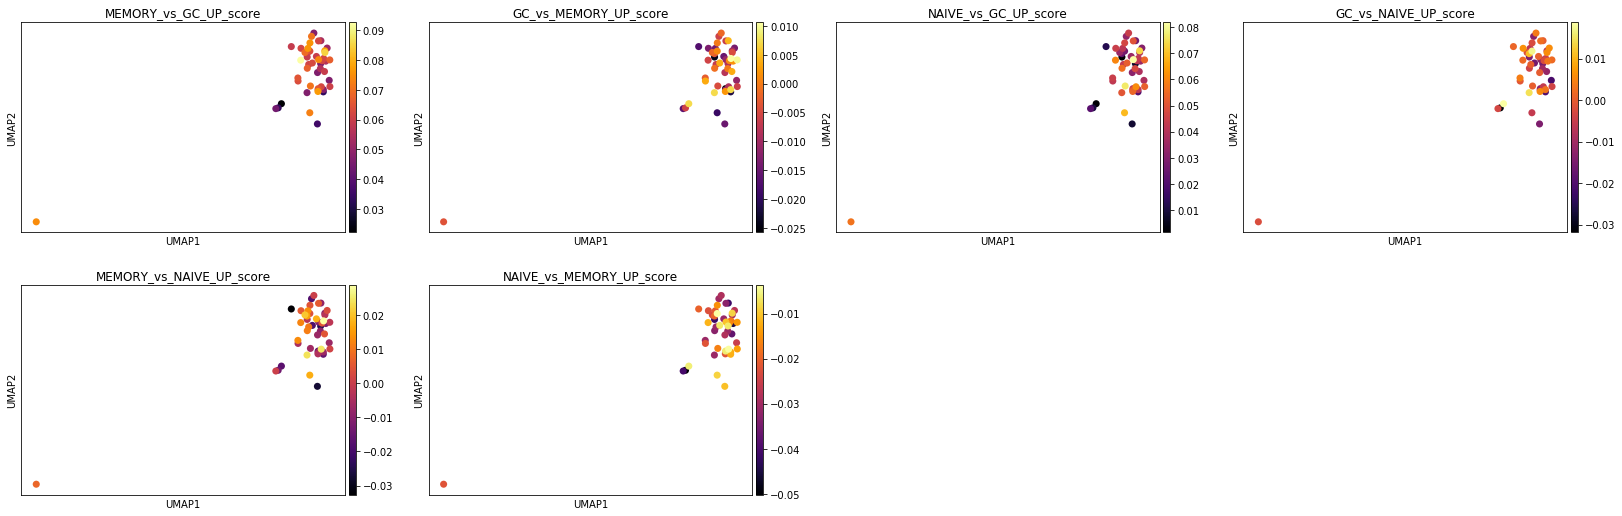

In [7]:
sc.pl.umap(bdata, color = [str(gs)+'_score' for gs in genesets.columns], color_map = 'inferno', size = 200)

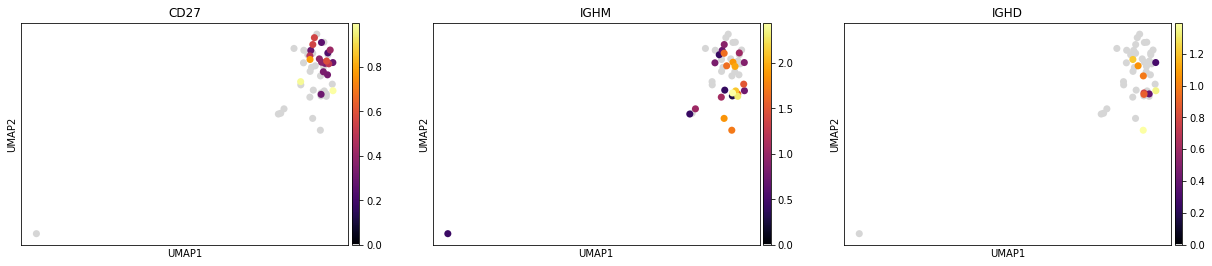

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

sc.pl.umap(bdata, color = ['CD27', 'IGHM', 'IGHD'],size = 200, color_map = newcmp)

In [44]:
bdata.raw.var.index.get_loc('CD27')

13234

In [45]:
bdata.raw.var.index.get_loc('IGHD')

15481

In [47]:
bdata.raw.X[:,13234][bdata.raw.X[:,13234] > 0].shape

(1, 19)

In [48]:
bdata.raw.X[:,15481][bdata.raw.X[:,15481] > 0].shape

(1, 9)

In [49]:
test = bdata.raw.X[:,(13234,15481)]

In [68]:
test = pd.DataFrame(test.toarray(), columns = ['CD27', 'IGHD'])

In [79]:
# non-naive/unassigned
test[(test['CD27'] > 0) & (test['IGHD'] > 0)].shape

(4, 2)

In [80]:
# Memory
test[(test['CD27'] > 0) & (test['IGHD'] == 0)].shape

(15, 2)

In [81]:
# naive
test[(test['CD27'] == 0) & (test['IGHD'] > 0)].shape

(5, 2)

In [82]:
# non-naive/unassigned
test[(test['CD27'] == 0) & (test['IGHD'] == 0)].shape

(23, 2)

In [29]:
mnp = 

AnnData object with n_obs × n_vars = 13505 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Biopsy Location DETAIL', 'Biopsy Location BRIEF', 'Biopsy Location Co-ordinate', 'PMHx', 'celltype-immune', 'celltype-immune_group'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap', 'celltype-immune_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'